In [1]:
%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
matplotlib.rc('font', family='Verdana')
from scipy.stats import boxcox
import sklearn
from sklearn.cluster import MeanShift, estimate_bandwidth
from statsmodels.api import OLS
from scipy import stats
import statsmodels.api as sm
from itertools import product as product
import os
import time
import winsound
import pickle
import datetime
import statsmodels as sms
import warnings


Populating the interactive namespace from numpy and matplotlib


# Ссылка на submission
https://inclass.kaggle.com/submissions/5152764/5152764.zip

https://inclass.kaggle.com/c/yellowtaxi/leaderboard






In [2]:
CALCULATE_PARAMETERS = False # загружается из файла модель, обученная на одном месяце, 
CALCULATE_PARAMETERS = True # Если True,  рассчитывает АРИМЫ (долго)
                            # перебирает разные наборы параметров, ищет лучший набор


In [3]:
CALCULATE_PREDICTION = False # загружается из файла прогноз
CALCULATE_PREDICTION = True # Если = True, рассчитывает прогноз


In [4]:
CALCULATE_REGIONS = False # рассчитать регрессии для каждого региона 
CALCULATE_REGIONS = True

In [5]:
MAY = False # Если MAY = False, не рассчитывать конечный прогноз для мая, а загружать из файла
#MAY = True # Если MAY = True,  рассчитывает конечный прогноз для мая


In [6]:
JUNE = False # Если JUNE = False, не рассчитывать для июня, а загружать из файла
JUNE = True # Если JUNE = True,  рассчитывает конечный июньские прогнозы


#### Сначала идут функции и классы, тело программы начинается после объявления функций

In [7]:
# Класс для нормализации рядов
class normalize_class:

    # Преобразование - normalize
    def normalize(self, data):
        self.mean = data.mean()
        self.std = data.std()
        return (data - self.mean)/self.std

    # Обратное преобразование 
    def inverse(self, normalized_data):
        return(normalized_data*self.std+self.mean)


# Класс для преобразования Бокса-Кокса
class boxcox_class:
    def __init__(self, shift):
        self.shift = shift   # Сдвиг ряда вверх, т.к. ряд должен быть строго больше нуля
    
    # Преобразование Бокса-Кокса
    def boxcox(self, data, lmbda=None):
        if lmbda == None:
            boxcox_data, self.lmbda, self.lmbda_confint = boxcox( x=data+self.shift, lmbda=lmbda, alpha=0.05 )
            boxcox_data = pd.Series(data=boxcox_data, index=data.index)
        else:
            boxcox_data = boxcox( x=data+self.shift, lmbda=lmbda, alpha=0.05 )
            self.lmbda = lmbda
            self.lmbda_confint = (lmbda, lmbda)
        return boxcox_data

    # Обратное преобразование Бокса-Кокса
    def inverse(self, data):
        if self.lmbda == 0:
            return(np.exp(data)-self.shift)
        else:
#            return(np.exp(np.log(abs( self.lmbda*data+1)/self.lmbda) ) - self.shift)
            return(np.exp(np.log(self.lmbda*data+1)/self.lmbda) - self.shift)



In [8]:
# Функция строит графики кластеров
# Графики нужны для наглядности, чтобы посмотреть на данные
def plot_clusters_histogram():
    # Распределение регионов по кластерам

    distr = [len(cluster) for cluster in clusters]
    plt.figure(figsize=(3,2))
    plt.hist(distr)

    print('{0} clusters'.format( len(clusters)))
    print(distr, sum(distr))
    

def plot_clusters():
    
    # Графики кластеров
    for n, cluster in enumerate(clusters):
        plt.figure(figsize=(20,10))
        for col in cluster[:5]:
            y.loc[year2016][col].plot(legend=str(col))
            plt.title(' cluster {0}, regions within this cluster = {1}; {2} clusters'.format(
                        n, len(cluster),len(clusters)))
        

In [9]:
# Функция вычисления регрессии
def regr(y_target, train_per, verbose=False, plot_graph=False):

    y_target = pd.Series(data=y_target, index=y.index)
    result = pd.DataFrame(index=y.index)

    ols = OLS(exog=data.loc[train_per], endog=y_target.loc[train_per]).fit()


    result['ols_forecast'] = pd.Series( data = ols.predict(exog = data ), index = y.index )
    result['ols_resid'] = pd.Series( data = y_target - result['ols_forecast'], index = y.index )


    if verbose:
        print('средняя остатков регрессии на обучающей выборке = ', result.residues.loc[train].mean())
        print('размерность регрессионных признаков', data.loc[train].shape, len(ols.params.nonzero()[0]))
        print("Критерий Стьюдента на равенство средней нулю: p=%f \n" % stats.ttest_1samp(result.residues.loc[train], 0)[1])

        print('средняя остатков  прогноза регрессии в апреле = ', result.residues.loc[april].mean())
        print("Критерий Стьюдента на равенство средней нулю: p=%f \n" % stats.ttest_1samp(result.residues.loc[april], 0)[1])

        print('средняя остатков  прогноза регрессии в мае = ', result.residues.loc[may].mean())
        print("Критерий Стьюдента на равенство средней нулю: p=%f" % stats.ttest_1samp(result.residues.loc[may], 0)[1])
        print("отношение средних май/апрель {} \n".format( result.residues.loc[may].mean()/result.residues.loc[april].mean()) )

        print('средняя остатков  прогноза регрессии в июне = ', result.residues.loc[june].mean())
        print("Критерий Стьюдента на равенство средней нулю: p=%f" % stats.ttest_1samp(result.residues.loc[june], 0)[1])
        print('отношение средних июнь/апрель {} \n'.format( result.residues.loc[june].mean()/result.residues.loc[april].mean()) )


    if plot_graph:
        plt.figure(figsize(15,7))
        plt.plot(result.residues.loc[year2016], label='residuals', )
        plt.plot(y_target.loc[year2016], label = 'y boxcox')
        plt.plot(result.forecast.loc[year2016], label = 'regression')
        plt.legend()

    return result


In [10]:
# Функция дифференцирования для получения стационарного ряда
def diff(residuals, n, period, calculate=False):
    
    if not calculate or len(residuals) <= n:
        return None

    ols_resid = residuals[n].ols_resid
    
    # Сезонное дифференцирование
    shiftS = 24
    residualsS = (ols_resid.loc[period] - ols_resid.loc[period].shift(shiftS))[shiftS:]

    # Дифференцирование на единичный лаг
    shift1 = 1
    residualsSminus1 = (residualsS - residualsS.shift(shift1))[shift1:]


    acf_shift = shiftS+shift1
    
    # Декомпозиция - графики
    plt.figure(figsize(15,7))
    sm.tsa.seasonal_decompose(residualsSminus1).plot()
    print( "Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(residualsSminus1[acf_shift:])[1])
    
    # коррелограммы - графики

    plt.figure(figsize=(20,5))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(residualsSminus1[acf_shift:], lags = 200, ax=ax, title='(Q,q) ACF ')
    plt.grid()

    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(residualsSminus1[acf_shift:], lags = 200, ax=ax, title='(P,p) PACF ')
    plt.grid()

    # Посмотрим поближе на коррелограммы - графики
    
    plt.figure(figsize=(20,5))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(residualsSminus1[acf_shift:], lags = 50, ax=ax, title='(Q,q) ACF ')
    plt.grid()

    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(residualsSminus1[acf_shift:], lags = 50, ax=ax, title='(P,p) PACF ')
    plt.grid()
    
    return acf_shift

In [11]:
# Функция сохранения в файл модели - чтобы каждый раз не перерасчитывать
def save_model(fname, *model):
    directory = os.path.dirname(fname)
    if not os.path.isdir(directory): 
        os.makedirs(directory)
    if os.path.isfile(fname): 
        os.remove(fname)
    
    with open(fname,"wb") as fout:
        pickle.dump(model, fout)

In [12]:
class arimas_class:
    def __init__(self, arima_train_period, train_period_id, 
                 arima_test_period,
                 path='4week_models/'):

        self.arima_train_period = arima_train_period
        self.arima_test_period = arima_test_period
        self.train_period_id = train_period_id

        self.best_param_table = pd.DataFrame(data=None)
        
        self.path=path

    # Внутренний метод класса arimas_class
    # рассчитывает одну ариму для одного набора параметров
    # период для обучения берет из параметров конструктора объекта класса
    # внешние методы используют только этот метод для обучения арим 
    # результат - 1 fitted арима для 1 набора параметров
    def calc_arima(self, param, data_series, period):

        # Вычисление модели АРИМА - у меня занимает 1-3 минуты на каждый набор параметров
        warnings.filterwarnings('ignore')
        result = None
        try:
            sarimax=sms.tsa.statespace.sarimax.SARIMAX(data_series[period], order=(param[0], param[1], param[2]), 
                                                       seasonal_order=(param[3], param[4], param[5], 24)).fit(disp=-1)
        except ValueError:
            #print('wrong parameters:', param)
            return None
        except LinAlgError: 
            #print('LinAlgError:', param)
            return None
        else:
            result = pd.Series(data = [self.train_period_id, param, 0, sarimax.aic, sarimax], 
                            index = ['train_period_id', 'param', 'Q', 'AIC', 'model'])
            
        warnings.filterwarnings('default')
        return result

    # Перебирает наборы параметров из списка list_of_parameters_list
    # результат - DataFrame 'train_period_id', 'param', 'aic', 'model'
    # отсортированный по Q - сумме абсолютых ошибок
    def get_best_params(self, calculate = False):
        if not calculate:
            fname=self.path + 'best_param_table'
            file = open(fname, 'rb')
            print(fname)
            self.best_param_table = pd.DataFrame(*pickle.load(file))
            file.close()
            return self.best_param_table

        else:
            for cluster_id, param_list, center in zip(cluster_ids, list_of_parameters_list, centers_):
                print('\n {0} parameters for cluster {1}'.format(len(param_list), cluster_id))
                bestQ = np.inf
                best_params = pd.DataFrame()
                for param in param_list:
                    arima = self.calc_arima(param, center.ols_resid, self.arima_train_period)

                    if arima is not None:
                        if arima.model is not None:
                            predict_values = arima.model.predict(start=len(self.arima_train_period)-1, 
                                                                 end=len(self.arima_train_period)+
                                                                 len(self.arima_test_period)-2)
                            #arima.Q = sum([abs(x) for x in (predict_values-center.ols_resid[self.arima_test_period].values)])
                            arima.Q = arima.AIC
                            if arima.Q < bestQ:
                                bestQ = arima.Q
                                best_params = pd.Series(data=arima, name=cluster_id)
                                    

                if best_params.empty:
                    winsound.Beep(600, 250)
                    print('\n\n_______________________________________________________________________')
                    print('\n best_params.empty for cluster_id = {0} \n'.format(cluster_id) )
                    print('\n_______________________________________________________________________')
                else:
                    save_model(self.path + 'heavy_model_'+str(cluster_id), best_params)
                    best_params.drop('model', inplace=True)
                    self.best_param_table = self.best_param_table.append(best_params)
                    
                    print('\n\n   cluster_id = {0} \nbest_params: \n{1}'.format(cluster_id, self.best_param_table.iloc[-1]) )

            save_model(self.path + 'best_param_table', self.best_param_table)
            return self.best_param_table
           
    # heavy_arima - читает с диска и возвращает сохраненную на диск модель - для экономии памяти
    # модели сразу сохраняются на диск, в памяти не хранятся,а при необходимости подгружаются
    def heavy_arima(self, cluster_id):

        file = open(self.path+'heavy_model_'+str(cluster_id), 'rb')
        heavy_arima = pd.Series( *pickle.load(file) )
        file.close()
        return heavy_arima

        
        
    def test_period_forecast(self, cluster_id):
        plt.figure(figsize=(20,10))
        predict_values = self.heavy_arima(cluster_id).model.predict(start=len(self.arima_train_period)-1, 
                                          end=len(self.arima_train_period)+
                                          len(self.arima_test_period)-1)

        forecast = pd.Series(data=predict_values.values[1:] + centers_[cluster_id].ols_forecast.loc[self.arima_test_period].values,
                             index=self.arima_test_period)
        forecast.plot(color='r', label='прогноз')

        center_series = pd.Series(data=ms.cluster_centers_[cluster_id], index=y.index)
        center_series.loc[self.arima_test_period].plot(color='g', label='Центр кластера')

        plt.title('прогноз модели арима+регрессия для центра кластера {0}, исходный ряд нормализован и сжат Боксом-Коксом'.format(cluster_id))
        plt.legend(loc=2)
        return None

    def test_period_forecast_residues(self, cluster_id):
        plt.figure(figsize=(20,10))
        predict_values = self.heavy_arima(cluster_id).model.predict(start=len(self.arima_train_period)-1, 
                                          end=len(self.arima_train_period)+
                                          len(self.arima_test_period)-1)

        forecast = pd.Series(data=predict_values.values[1:] + centers_[cluster_id].ols_forecast.loc[self.arima_test_period].values,
                             index=self.arima_test_period)

        center_series = pd.Series(data=ms.cluster_centers_[cluster_id], index=y.index)
        residues = abs(forecast - center_series.loc[self.arima_test_period])
        residues.plot(color='g', label='Остатки прогноза центра кластера')

        plt.title('Остатки прогноза центра кластера {0}'.format(cluster_id))
        plt.legend(loc=2)
        return None

    def predict_dynamic(self, data, test_period_id='_', dynamic_test_period=None, calculate=False):
        
        if not calculate:
            print('Predict_dynamic loaded, calculation skipped')
            file = open(self.path+'predict_dynamic'+test_period_id, 'rb')
            predict_dynamic = pd.DataFrame( *pickle.load(file) )
            file.close()
        else:
            predict_dynamic = pd.DataFrame()
            period = self.arima_test_period.union(dynamic_test_period)

            for cluster, cluster_id in zip(clusters, cluster_ids):
                tt = time.time()
                print('cluster', cluster_id)

                a = self.heavy_arima(cluster_id)
                order = a.param[:3]
                seasonal_order = [*a.param[3:], 24]
                
                for reg in cluster:
                    predict_series = pd.Series()

                    arima_fitted = sms.tsa.statespace.sarimax.SARIMAX(
                        endog=data[reg].loc[period],
                        order=order, 
                        seasonal_order = seasonal_order).filter(a.model.params)
                    
                    for test_time in dynamic_test_period:
                        t = period.get_loc(test_time)
                        predict_series = predict_series.append( arima_fitted.predict(t, t+5, dynamic=True) )

                    predict_dynamic[reg] =  predict_series.values

                print(round( (time.time() - tt)/60 , 2), 'min', 'cluster_id', cluster_id)
                    
            predict_dynamic = predict_dynamic.reindex(columns = y.columns, copy=True)
            save_model(self.path+'predict_dynamic'+test_period_id, predict_dynamic)
            print('calculation finished')
        return predict_dynamic
    

In [13]:
# регрессии каждого района рассчитать&сохранить или взять сохраненные
def get_regions(Calculate):
    fname = '4week_models/regions.dat'
    if Calculate:
        regions_ = [regr(y[reg], train_per=train) for reg in y]
        save_model(fname, regions_)
    else:
        file = open(fname, 'rb')
        regions_ = list(*pickle.load(file))
        file.close()
    return regions_
        



### Программа

In [14]:
# Считываем данные
ydata = pd.read_csv('../data/aggregated_hours_3week_2009.01_2016.06.csv', parse_dates=True, index_col='date')
print('размерность данных',ydata.shape)


размерность данных (65711, 102)


In [15]:
%%time
# ~25sec
# Дальше будем работать с таблицей нормализованных рядов
y = pd.DataFrame(index=ydata.index)

normalize_list = []  # Список параметров для обратного преобразования нормализации исходных рядов
for col in ydata.columns:
    normalize_list.append(normalize_class())
    y[col] = normalize_list[-1].normalize( ydata[col]) # нормализуем


Wall time: 779 ms


In [16]:
y.head(1)

1075     1076      1077     1125      1126      1127  \
date                                                                   
2009-01-01 -0.628629 -0.55061 -0.966585 -0.78395 -0.341748 -0.163005   

                1128      1129     1130      1131    ...         1630  \
date                                                 ...                
2009-01-01 -0.233078 -0.103026 -0.24798  0.319955    ...    -0.368854   

                1684      1733      1734      1783      2068      2069  \
date                                                                     
2009-01-01 -0.892259 -1.194887 -1.001547 -1.151968 -1.116931 -1.096966   

                2118     2119      2168  
date                                     
2009-01-01 -0.958386 -1.03697 -1.352462  

[1 rows x 102 columns]

In [17]:
# Делим на обучающую и тестовую выборки


# С января 2009 по март 2016 будем обучать регрессию
train = y['2009, 1':'2016, 3, 31 , 23 '].index


# Январь 2016 
jan = y['2016, 1, 1, 01': '2016, 1, 31 , 23 '].index

# Февраль 2016 
feb = y['2016, 2, 1': '2016, 2, 28 , 23 '].index

# Март 2016 
mar = y['2016, 3, 1': '2016, 3, 31 , 23 '].index

# Апрель 2016 - будем тестировать регрессию и обучать АРИМУ
april = y['2016, 4, 1': '2016, 4, 30 , 23 '].index

# Май - 
may = y['2016, 5, 1': '2016, 5, 31 , 23 '].index
may_test_per = y['2016, 4, 30, 23': '2016, 5, 31 , 17 '].index

# Июнь
june = y['2016, 6, 1': '2016, 6, 30 , 23 '].index
june_test_per = y['2016, 5, 31, 23': '2016, 6, 30 , 17 '].index

# Май-Июнь - будем использовать для прогноза всей модели (регрессия и АРИМА)
#may_june = y['2016, 5, 1': '2016, 6, 30 , 23 '].index

# 2016 год - для разных просмотров
year2016 = y['2016, 1, 1': '2016, 6, 30 , 23 '].index

8
221.099470045
8 clusters
[72, 5, 1, 1, 2, 1, 17, 3] 102
Wall time: 1min 3s


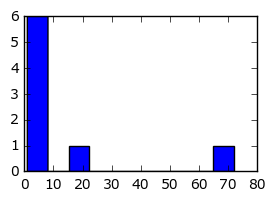

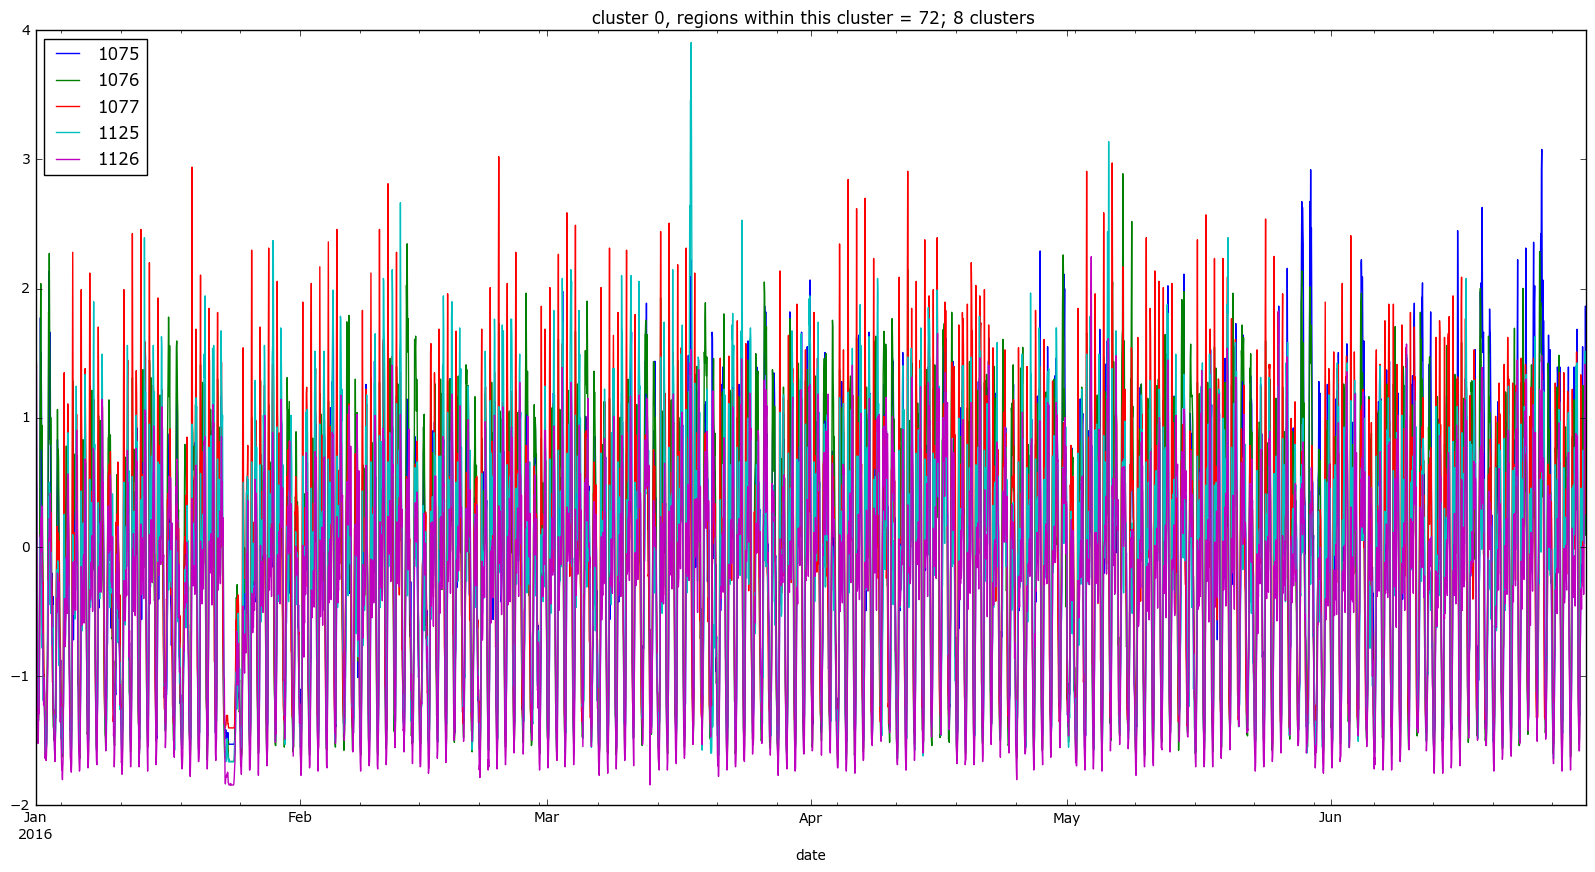

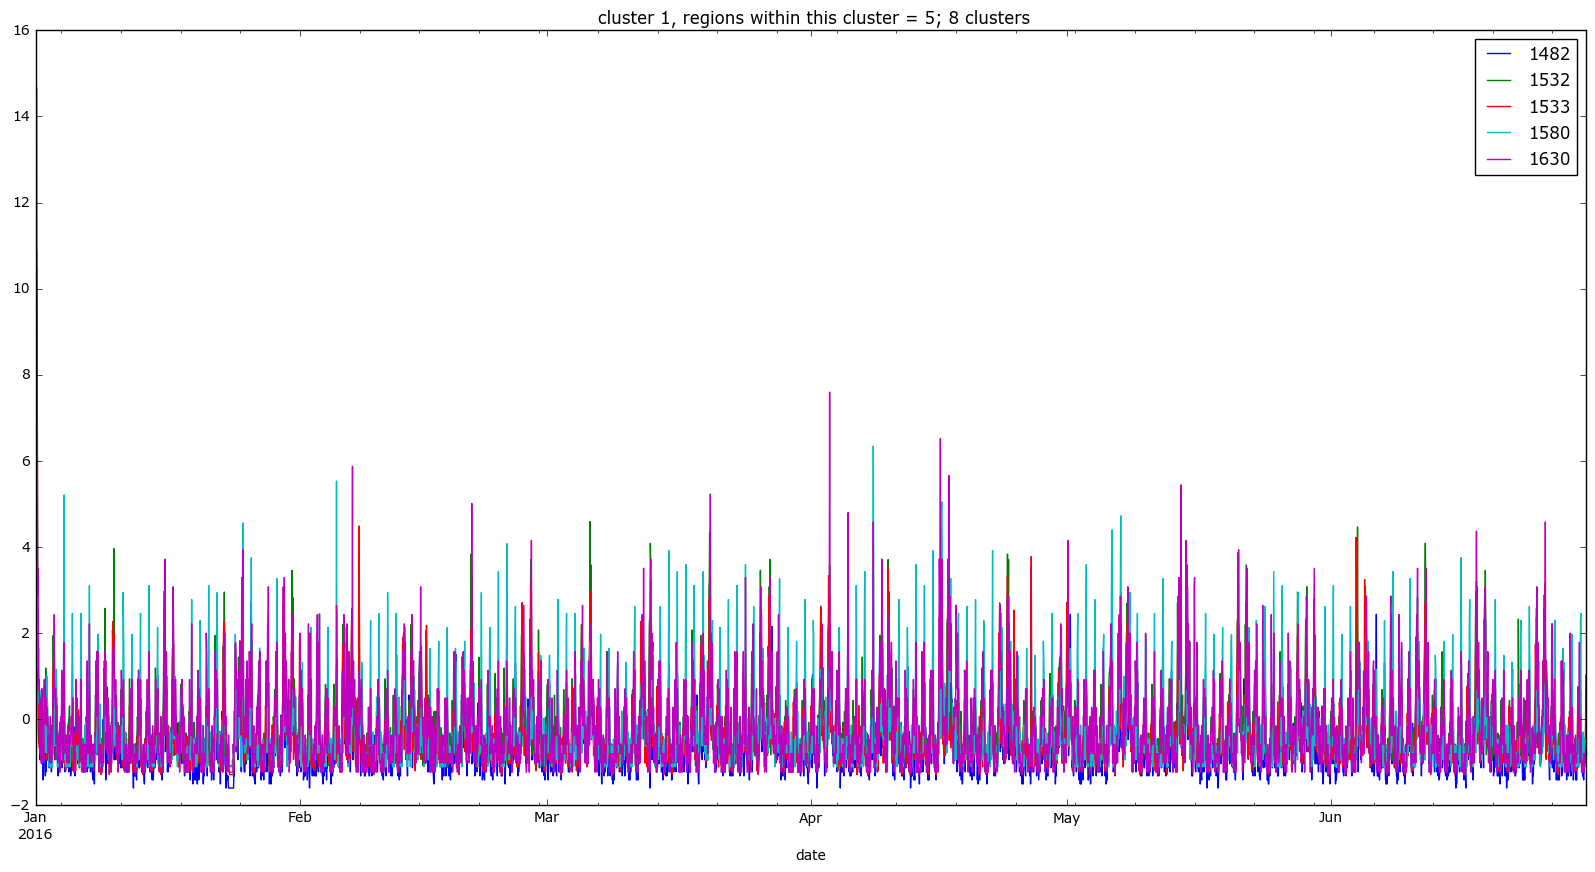

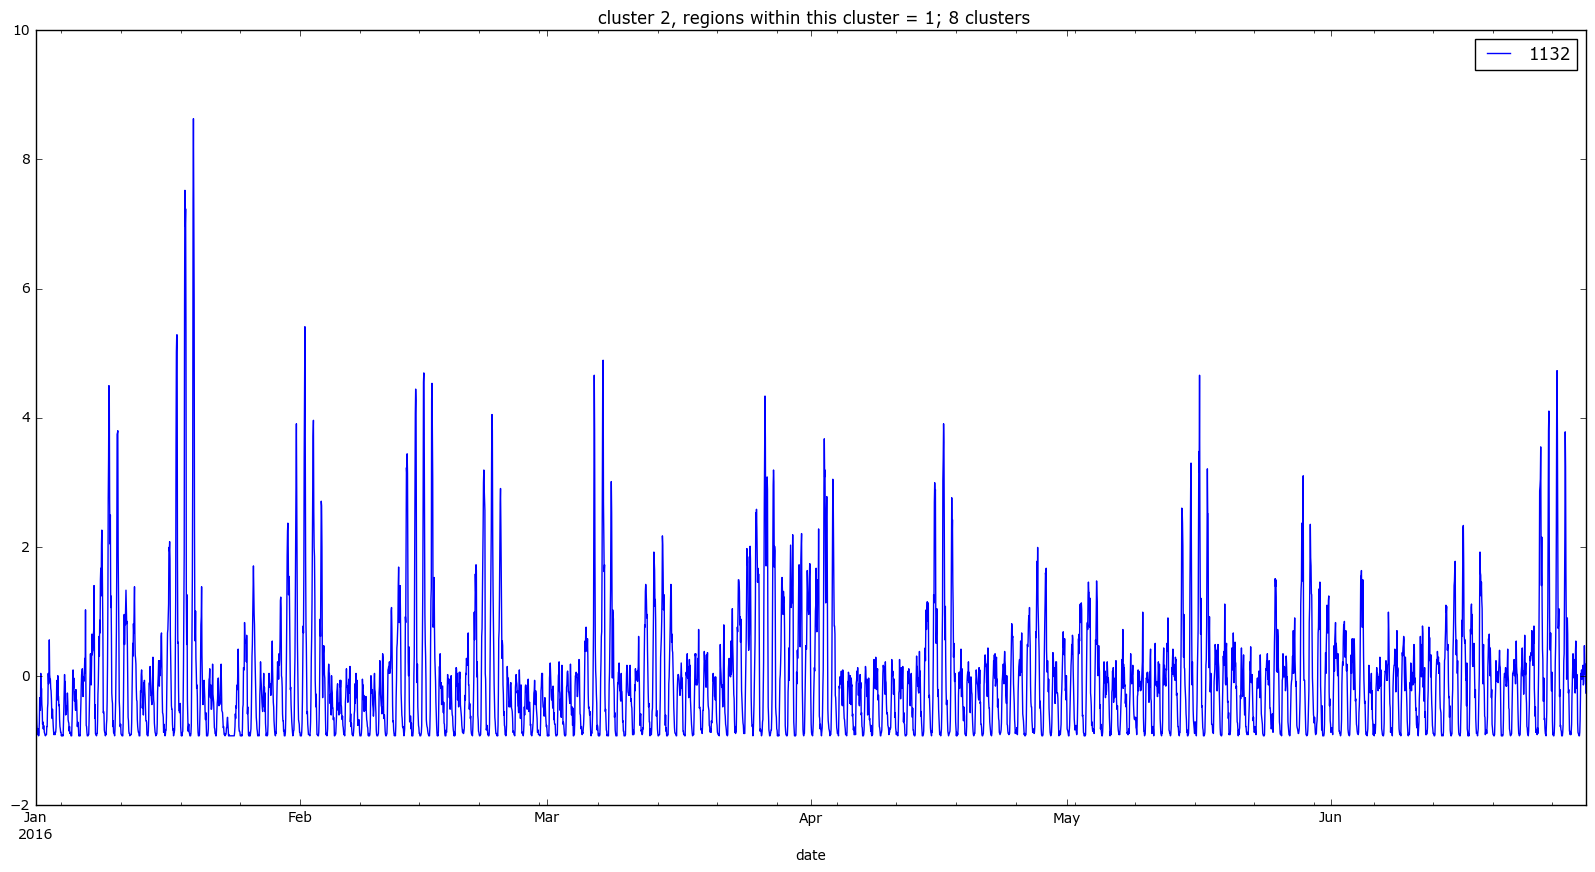

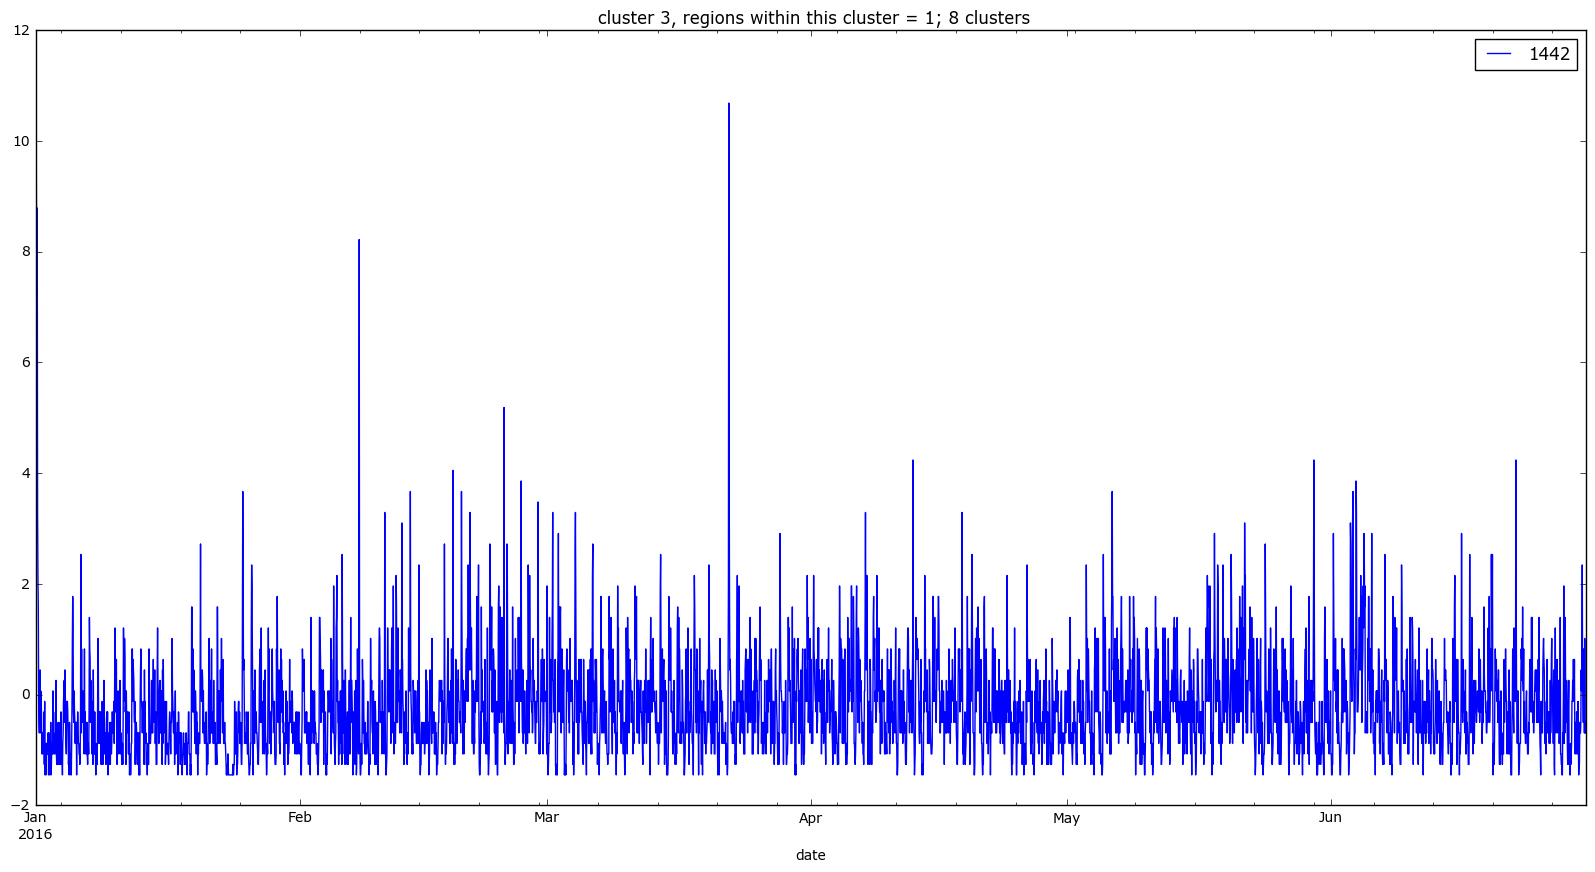

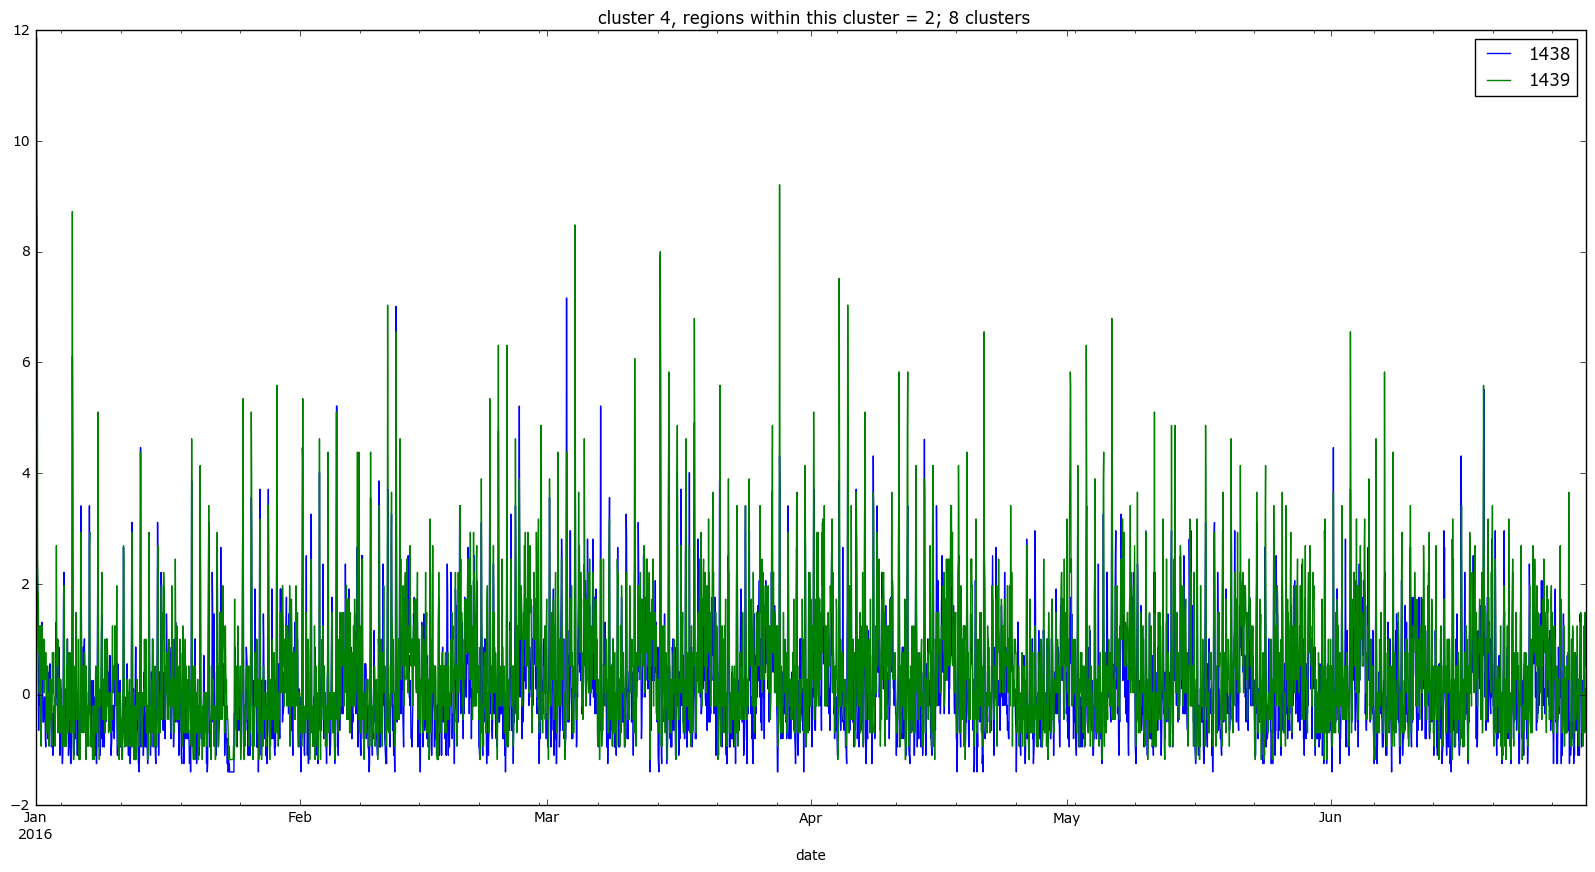

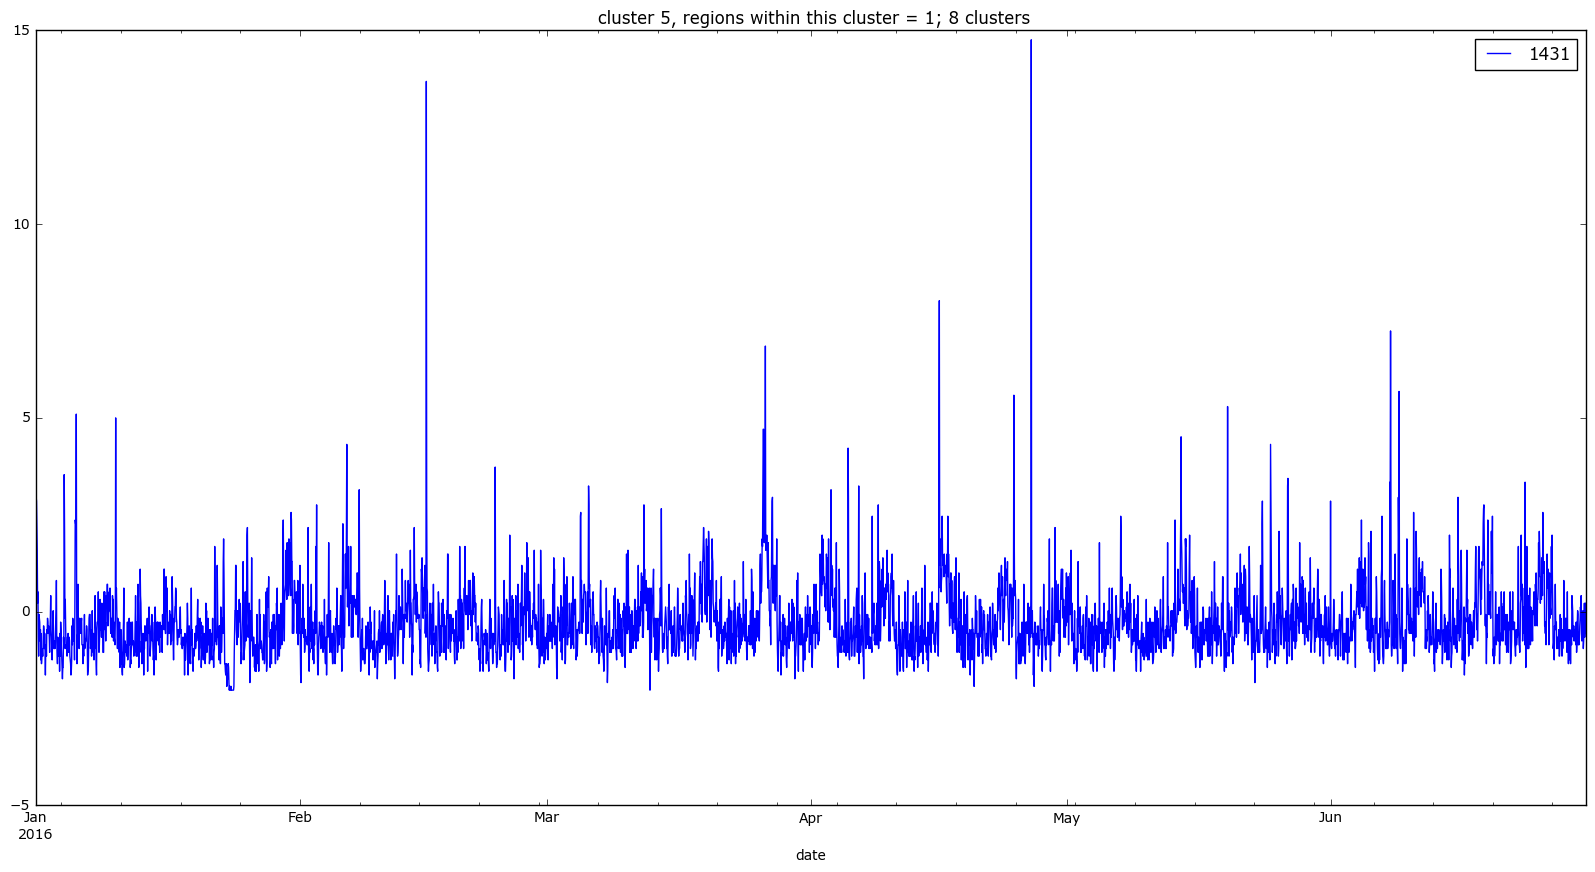

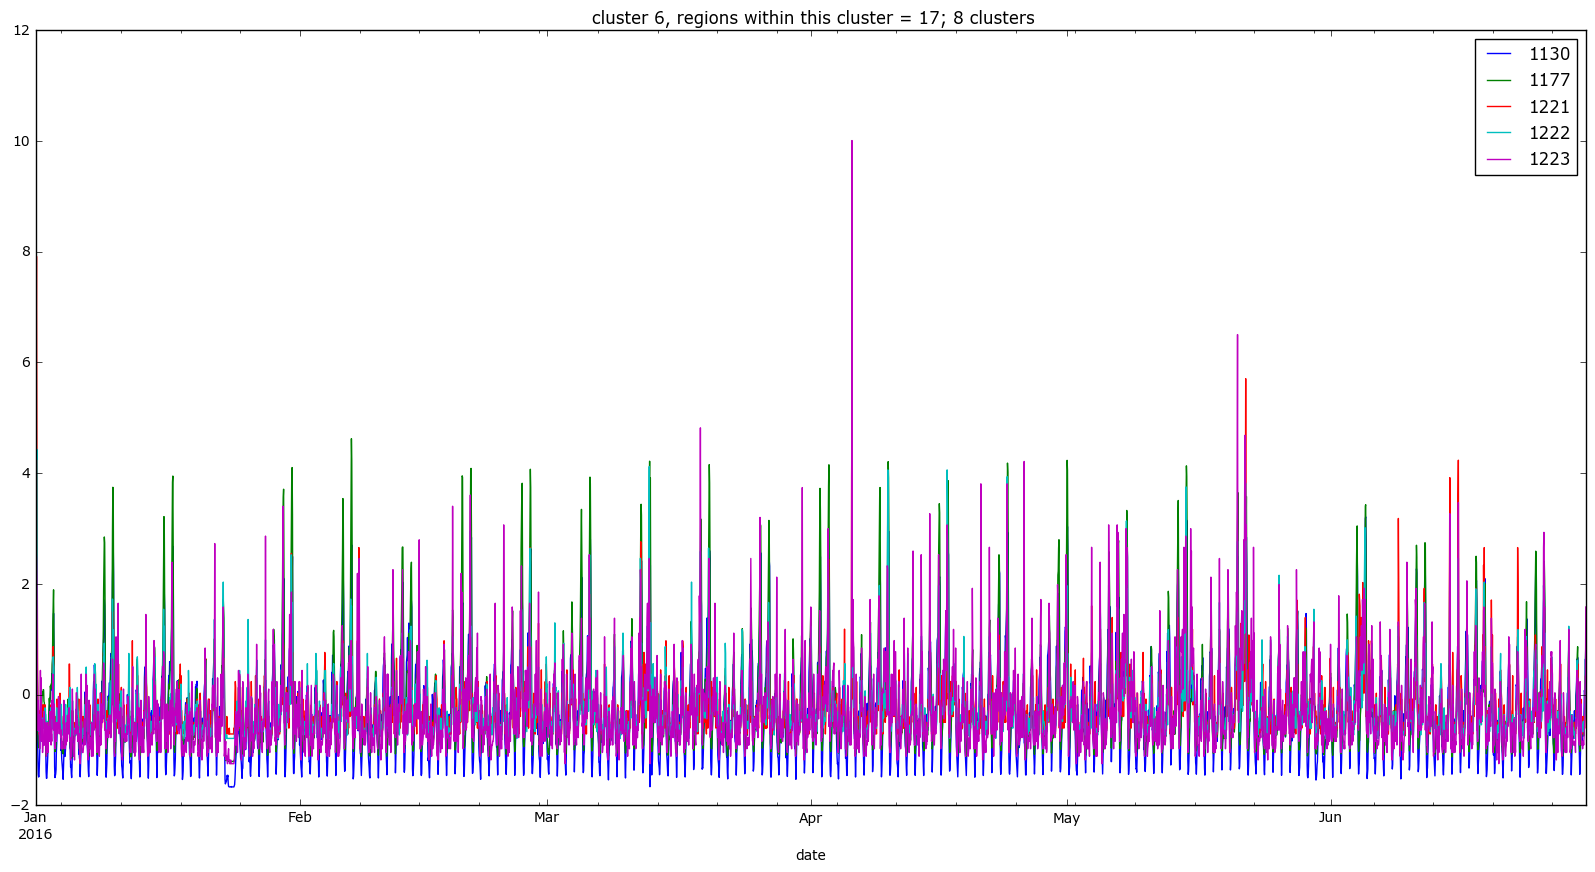

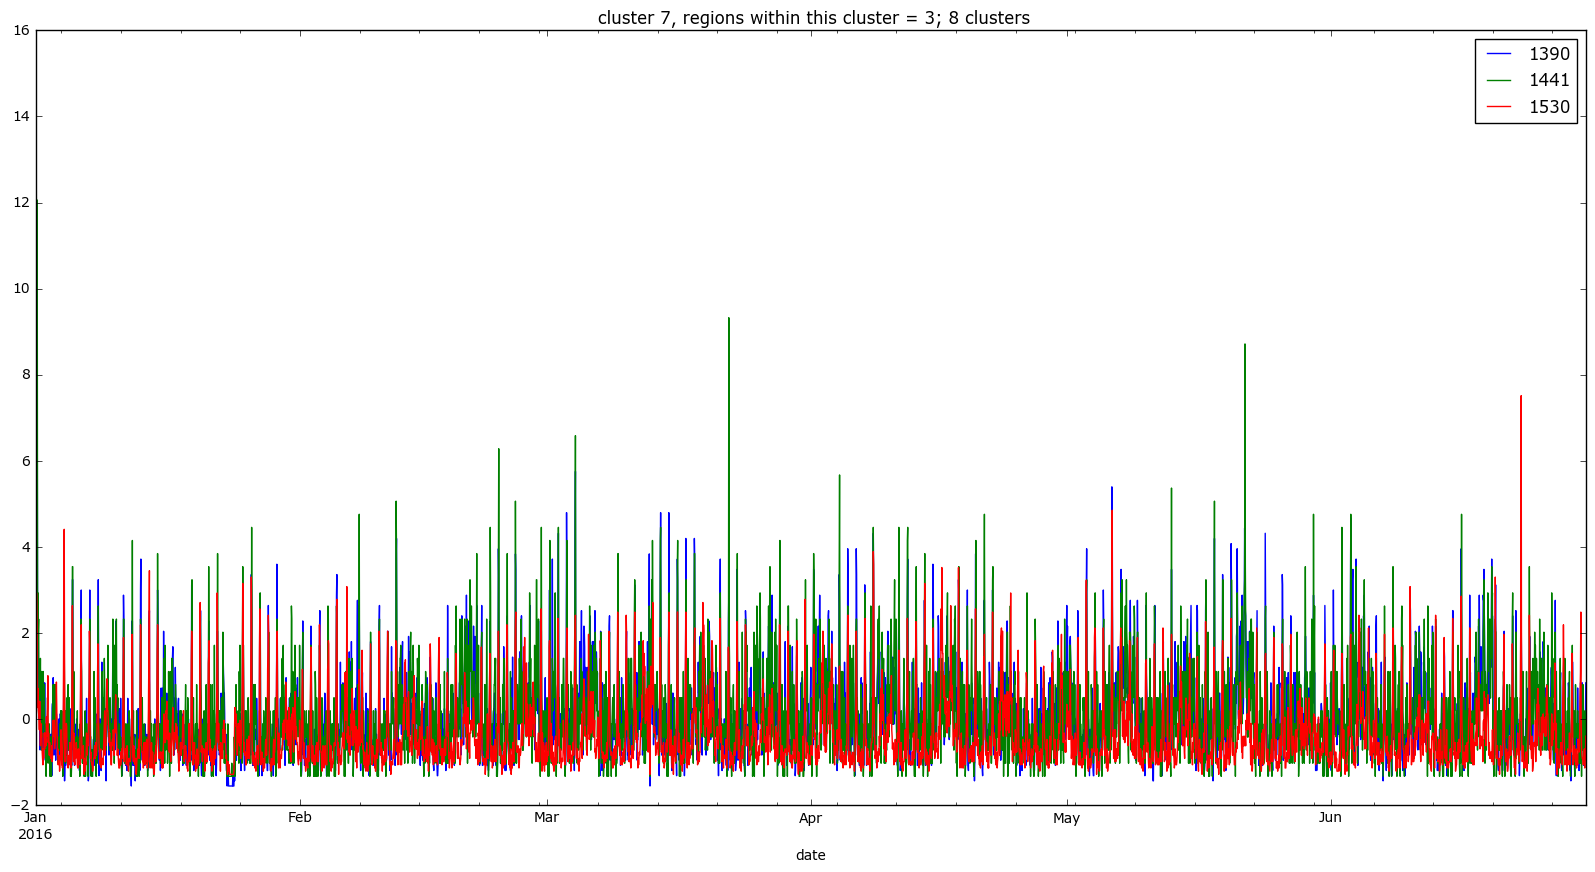

In [19]:
%%time
# ~50sec
# Кластеризуем
# Перебираем значения bandwidth в районе оценки, предложенной моделью
# Я попробовал разное количество кластеров, мне нравится 7 кластеров
# [100, 105, 110] 

bandwidth = estimate_bandwidth(y.values.T, quantile=0.23)

#bandwidth=622
ms = MeanShift(bandwidth=bandwidth,
               n_jobs=4, cluster_all=True, min_bin_freq=2).fit(y.values.T) 

clusters = [y.columns[ms.labels_ == n] for n in range(len(ms.cluster_centers_))]

print(len(clusters))
print(bandwidth)

# Разбиение на кластеры, с которыми будем работать
# Так оно выглядит на графиках

plot_clusters_histogram()
#plot_clusters()

In [19]:
#регрессионные признаки для учёта сезонностей и трендов
# Признаки регрессии для недели (168) и года (8766)

data = pd.DataFrame(index = y.index)
#K_data = pd.DataFrame(index = y.index)

trend = np.arange(1, len(data)+1)

K=5
# Недельные признаки
for i in np.arange(1, K+1):
    data['week_sin'+str(i)] = np.sin( trend*(2*np.pi*i/168.))
    data['week_cos'+str(i)] = np.cos( trend*(2*np.pi*i/168.))

# Годовые синусоиды
for i in np.arange(1, 3*K+1):
    data['year_sin'+str(i)] =  np.sin( trend*(2*np.pi*i/8766.))
    data['year_cos'+str(i)] = np.cos( trend*(2*np.pi*i/8766.))

# Признаки дня недели
for dow in range(7):
    data['dow'+str(dow)] = [1 if day == dow else 0 for day in data.index.dayofweek]
    
#Признаки номера недели в году
for nweek in range(52):
    data['nweek'+str(nweek)] = [1 if week_num == nweek else 0 for week_num in data.index.weekofyear]

# признаки месяца
for month in range(1,13):
    data['month'+str(month)] = [1 if mth == month else 0 for mth in data.index.month]

# Аномалия - январь 2016
anomaly_period = y['2016-01-23 06:00':'2016-01-24 7:00'].index
data['anomaly_2016_jan'] = [1 if (x in anomaly_period) else 0 for x in data.index]

# Тренд
data['trend'] = trend


In [20]:
# Центры кластеров

print(len(ms.cluster_centers_), 'центров кластеров')
cluster_ids = range(len(ms.cluster_centers_))

5 центров кластеров


In [21]:
%%time
# ~20sec
# Регрессия центров кластеров на сезонные признаки
# centers_ содержит ряды регрессии и остатков регрессии каждого центра кластера
# остатки регрессий центров кластеров потом подаются для обучения моделей ARIMA
# впоследствии обучать будем по одной ариме на каждый центр кластера

centers_ = [regr(center, train_per=train) for center in ms.cluster_centers_]

Wall time: 14 s


Критерий Дики-Фуллера: p = 1.68039363263e-21


25

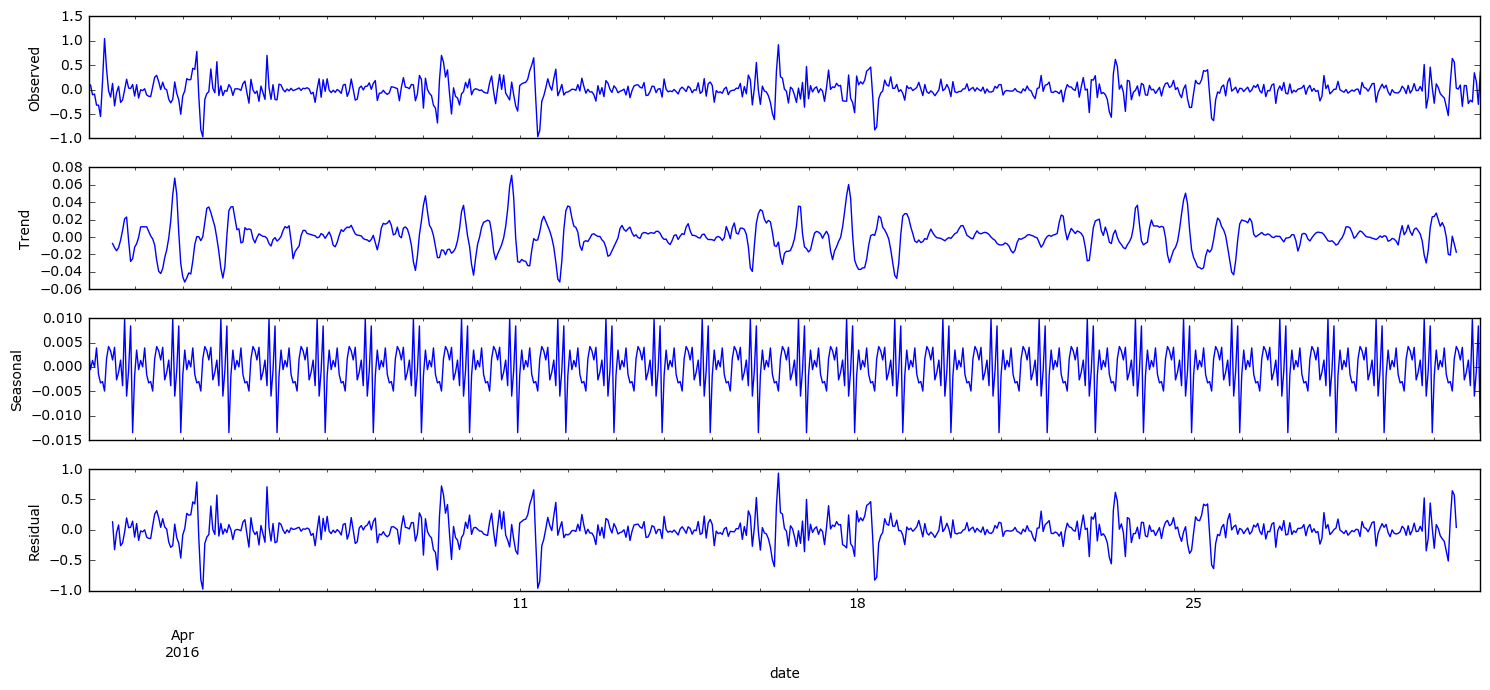

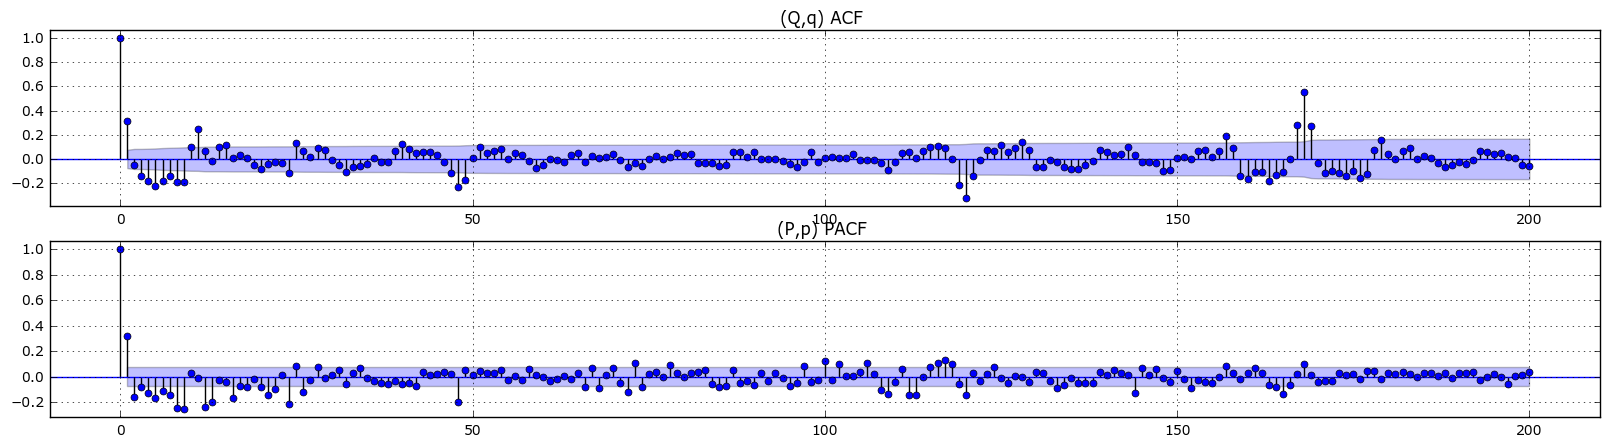

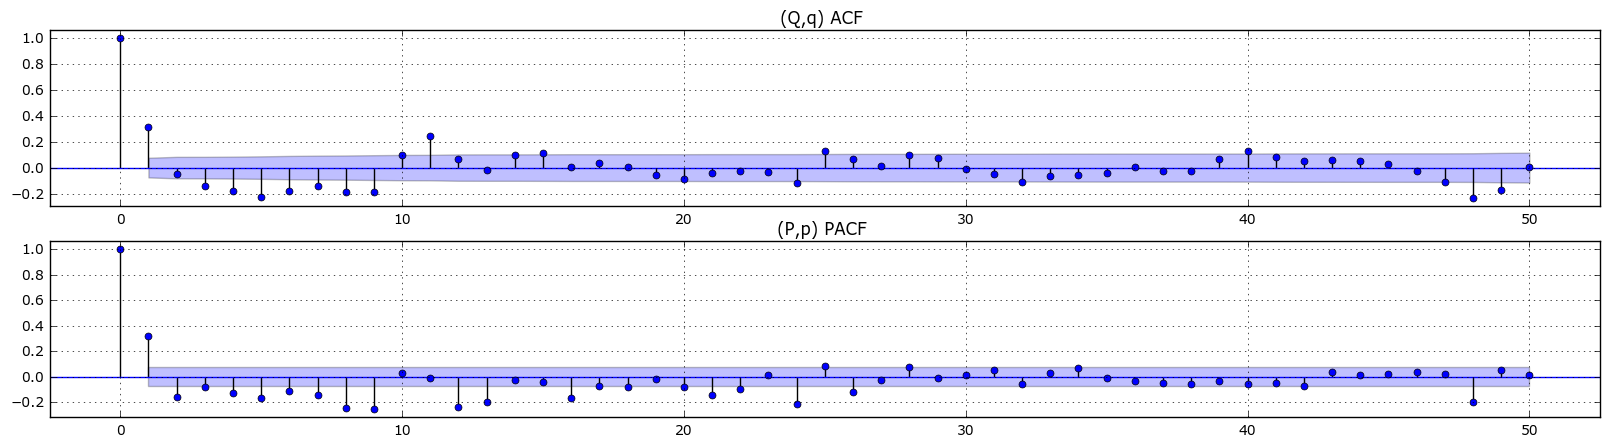

In [22]:
# Посмотрим на декомпозицию, коррелограммы, подбираем наборы параметров для АРИМ
list_of_parameters_list = []    # Список списков (наборов) параметров, 

diff(centers_, 0, april, CALCULATE_PARAMETERS) 

In [23]:
# Подбор начальных параметров аримы для кластера 0

ps=[1,2,5,9]
ds=[1]
qs=[1,5,9,11]
Ps=[0,1,2]
Ds=[1]
Qs=[0,1,2]


list_of_parameters_list.append( list(product(ps, ds, qs, Ps, Ds, Qs)) )
print( len(list_of_parameters_list[-1]), 'наборов параметров') 


144 наборов параметров


Критерий Дики-Фуллера: p = 2.62300006471e-21


25

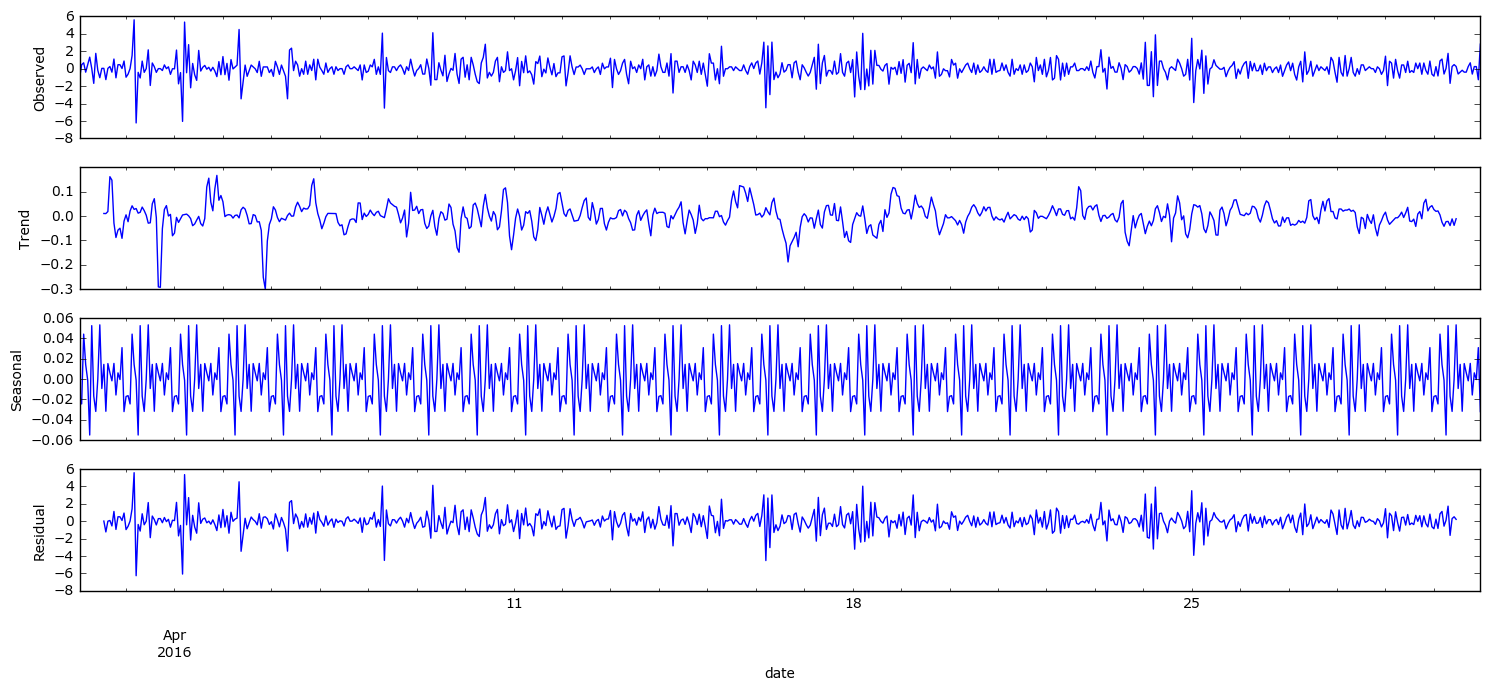

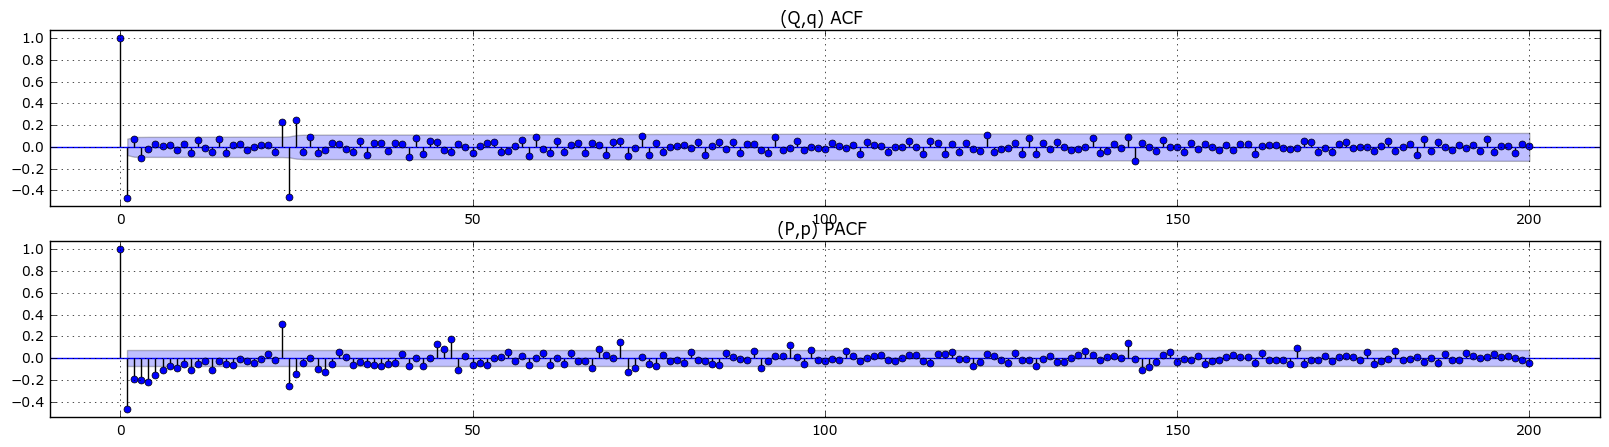

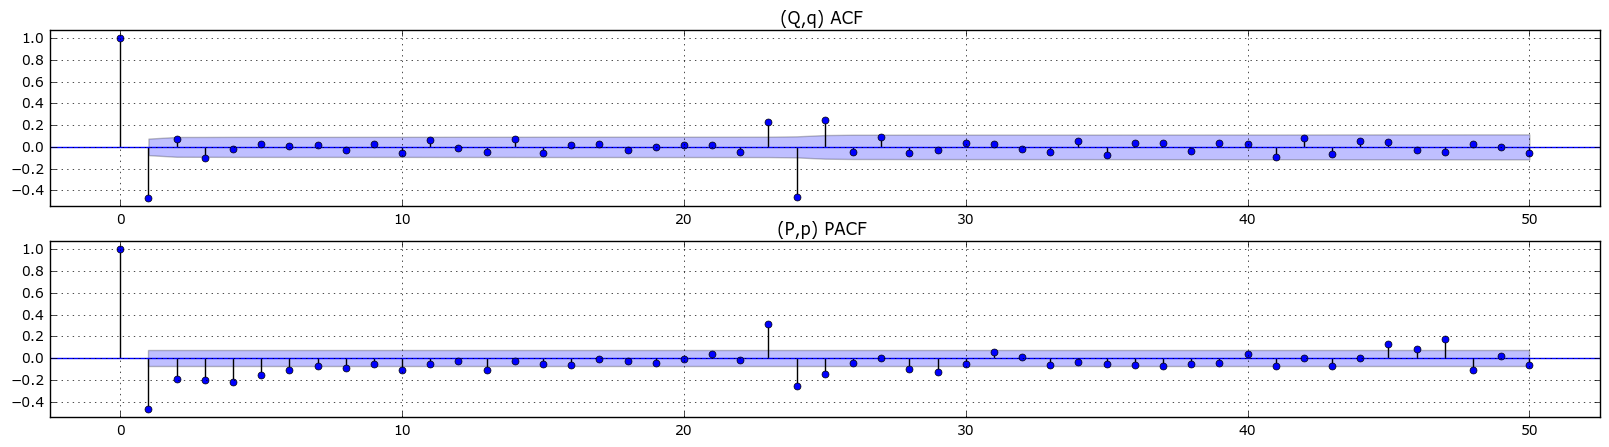

In [24]:
diff(centers_, 1, april, CALCULATE_PARAMETERS) 

In [25]:
# Подбор начальных параметров аримы для кластера 1

ps=[1,5,10]
ds=[1]
qs=[1]
Ps=[1,2]
Ds=[1]
Qs=[1]

list_of_parameters_list.append( list(product(ps, ds, qs, Ps, Ds, Qs)) )
print( len(list_of_parameters_list[-1]), 'наборов параметров') 


6 наборов параметров


Критерий Дики-Фуллера: p = 7.07953355088e-17


25

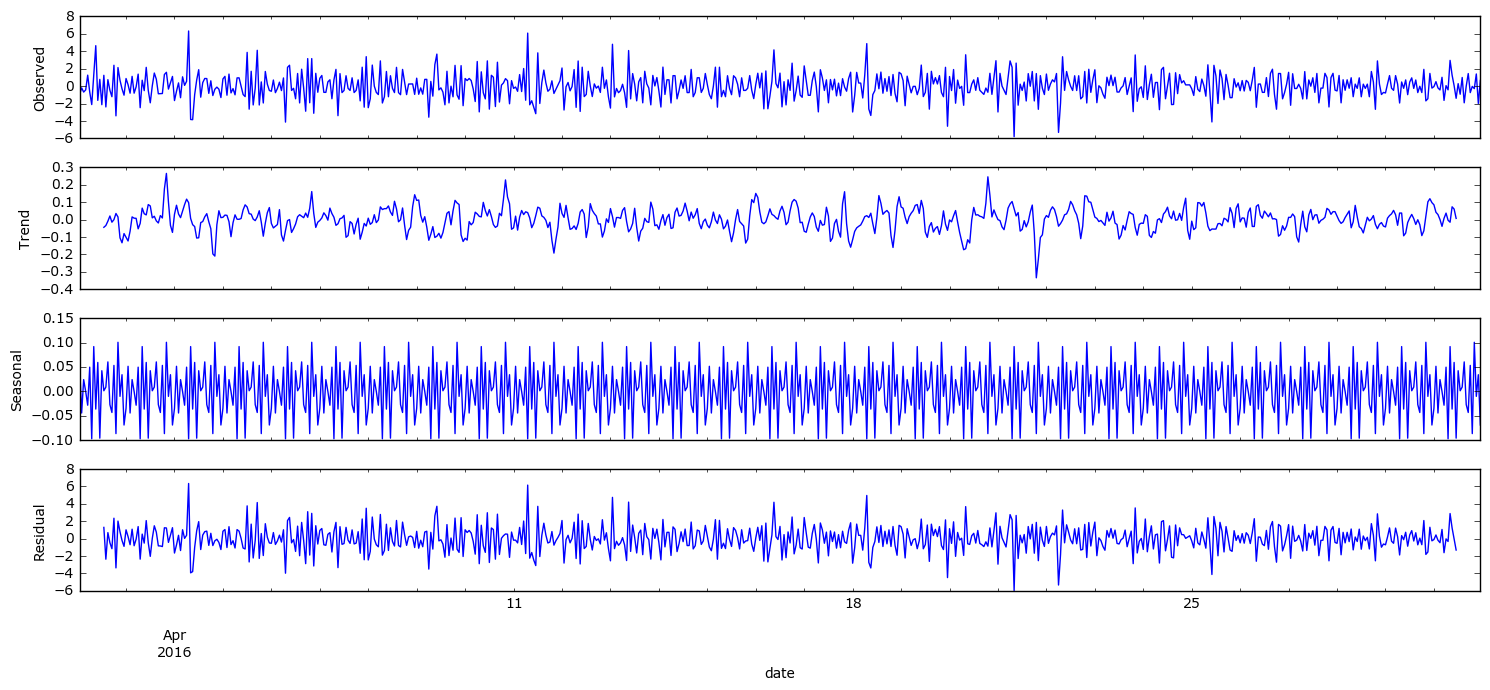

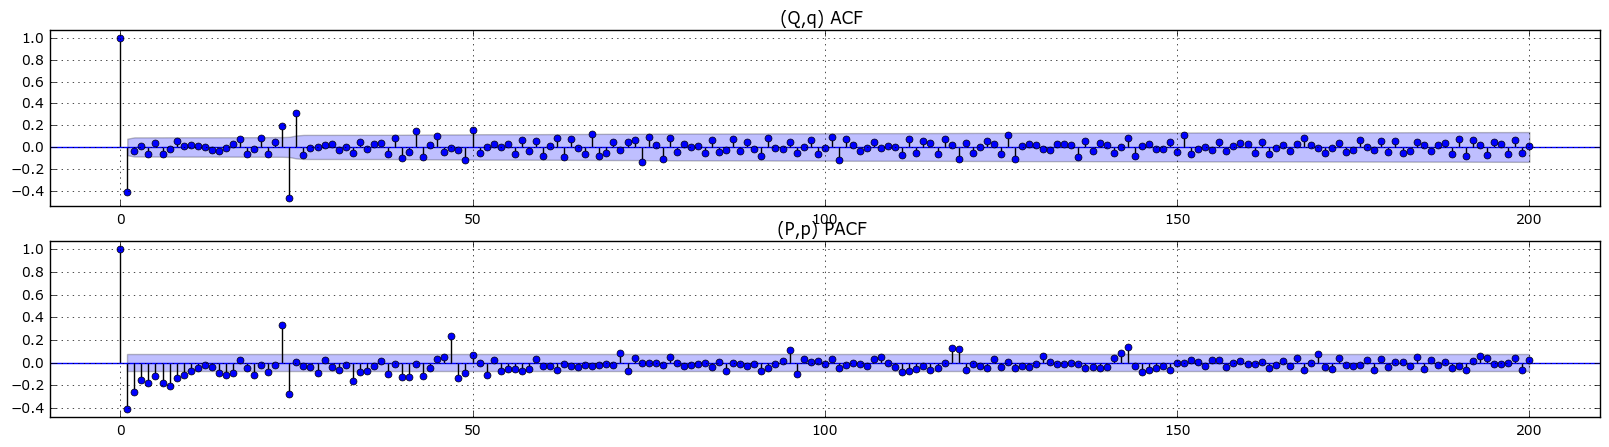

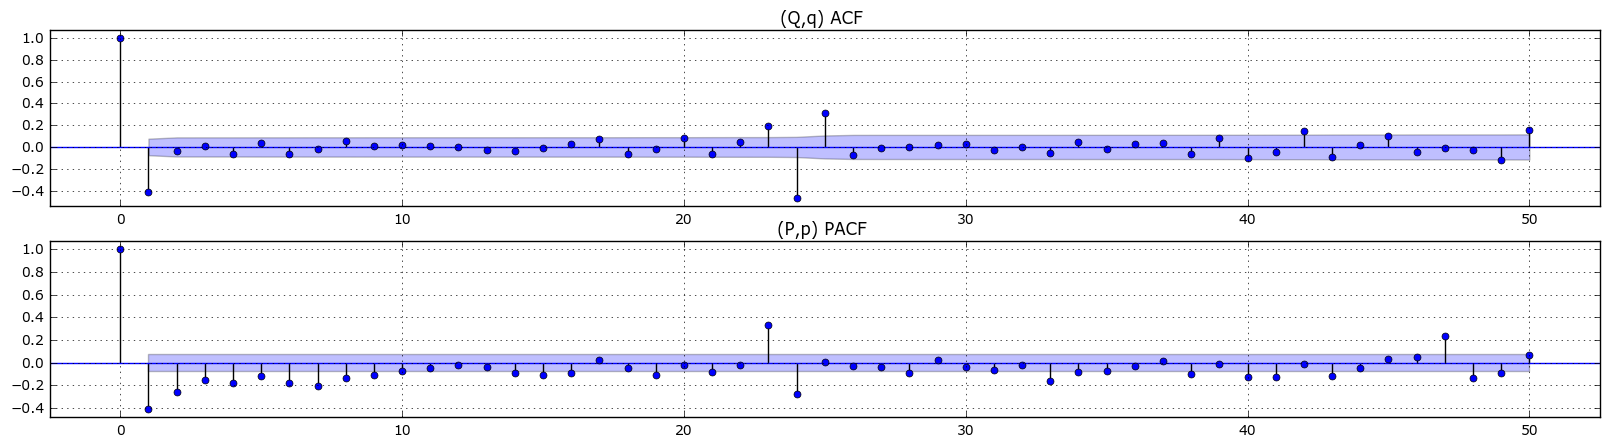

In [26]:
diff(centers_, 2, april, CALCULATE_PARAMETERS) 

In [27]:
# Подбор начальных параметров аримы для кластера 2

ps=[1,6,7,8,9]
ds=[1]
qs=[1]
Ps=[1,2]
Ds=[1]
Qs=[1]

list_of_parameters_list.append( list(product(ps, ds, qs, Ps, Ds, Qs)) )
print( len(list_of_parameters_list[-1]), 'наборов параметров') 


10 наборов параметров


Критерий Дики-Фуллера: p = 7.66976450233e-18


25

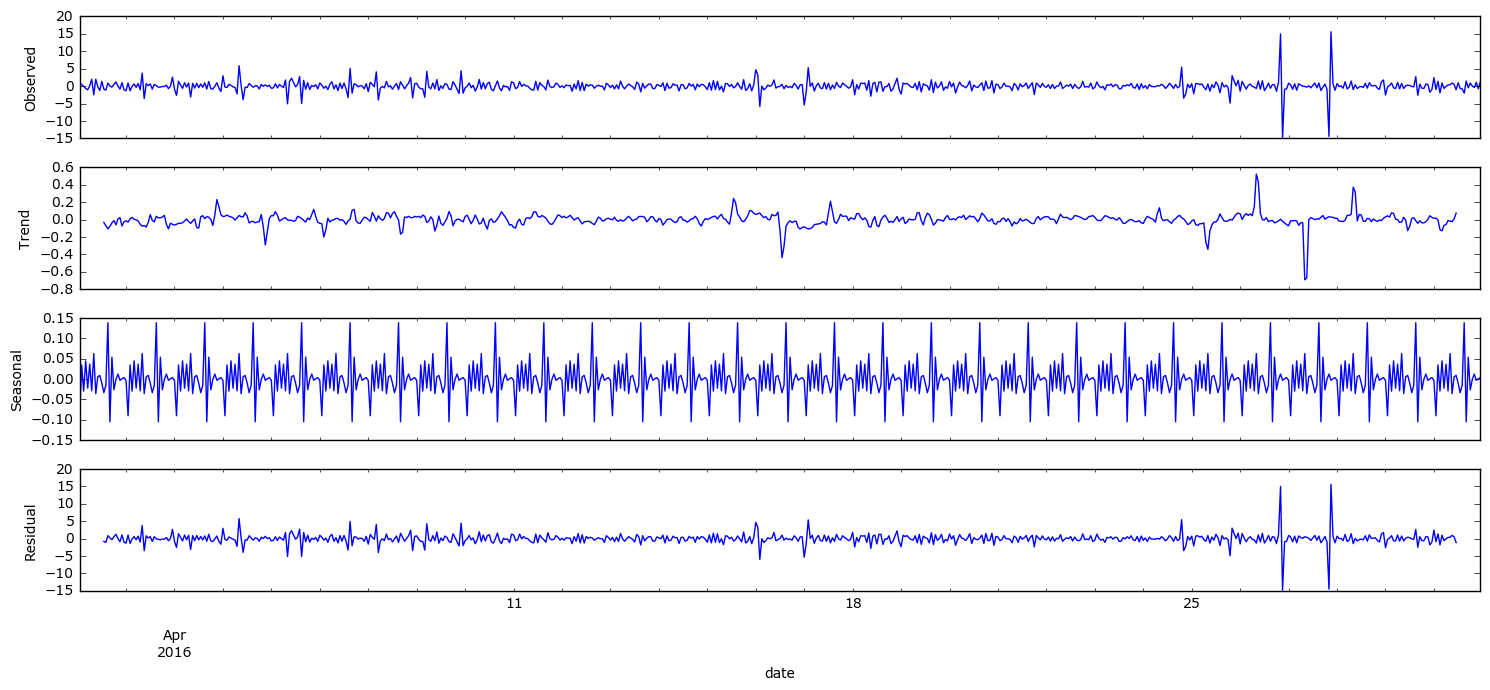

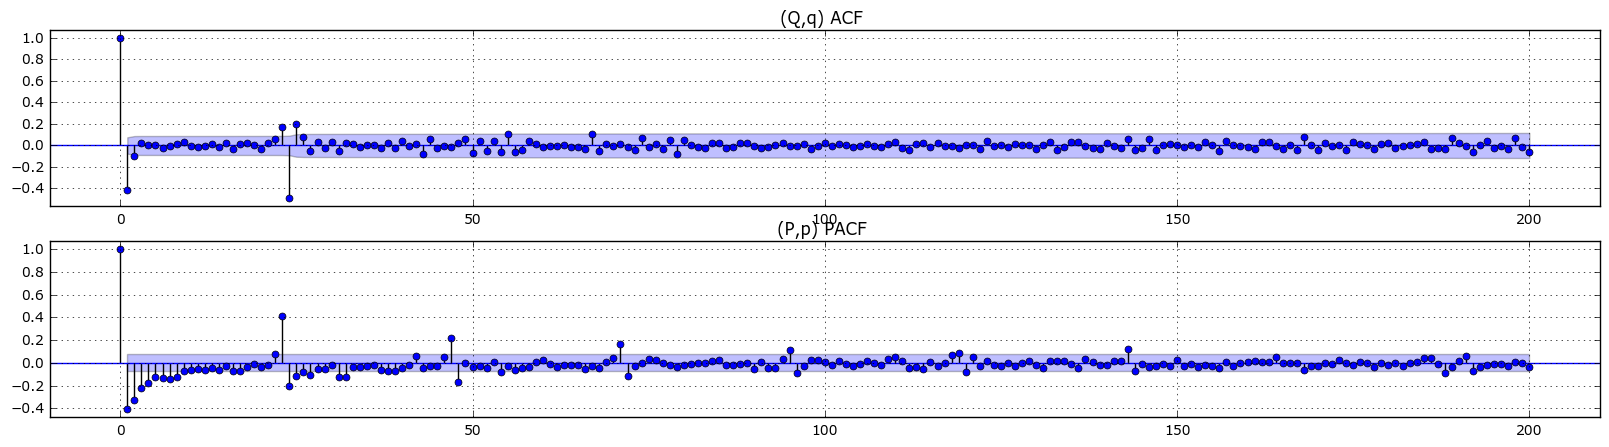

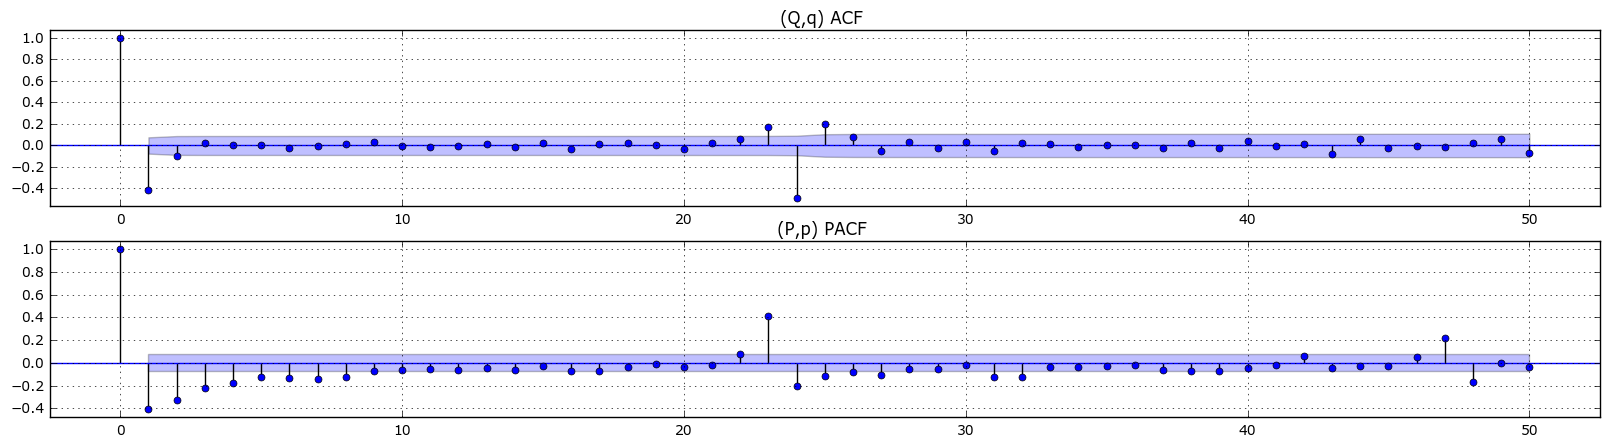

In [28]:
diff(centers_, 3, april, CALCULATE_PARAMETERS) 

In [29]:
# Подбор начальных параметров аримы для кластера 3

ps=[1,2,7,8]
ds=[1]
qs=[1]
Ps=[1,2]
Ds=[1]
Qs=[1]

list_of_parameters_list.append( list(product(ps, ds, qs, Ps, Ds, Qs)) )
print( len(list_of_parameters_list[-1]), 'наборов параметров') 


8 наборов параметров


Критерий Дики-Фуллера: p = 7.6994687783e-17


25

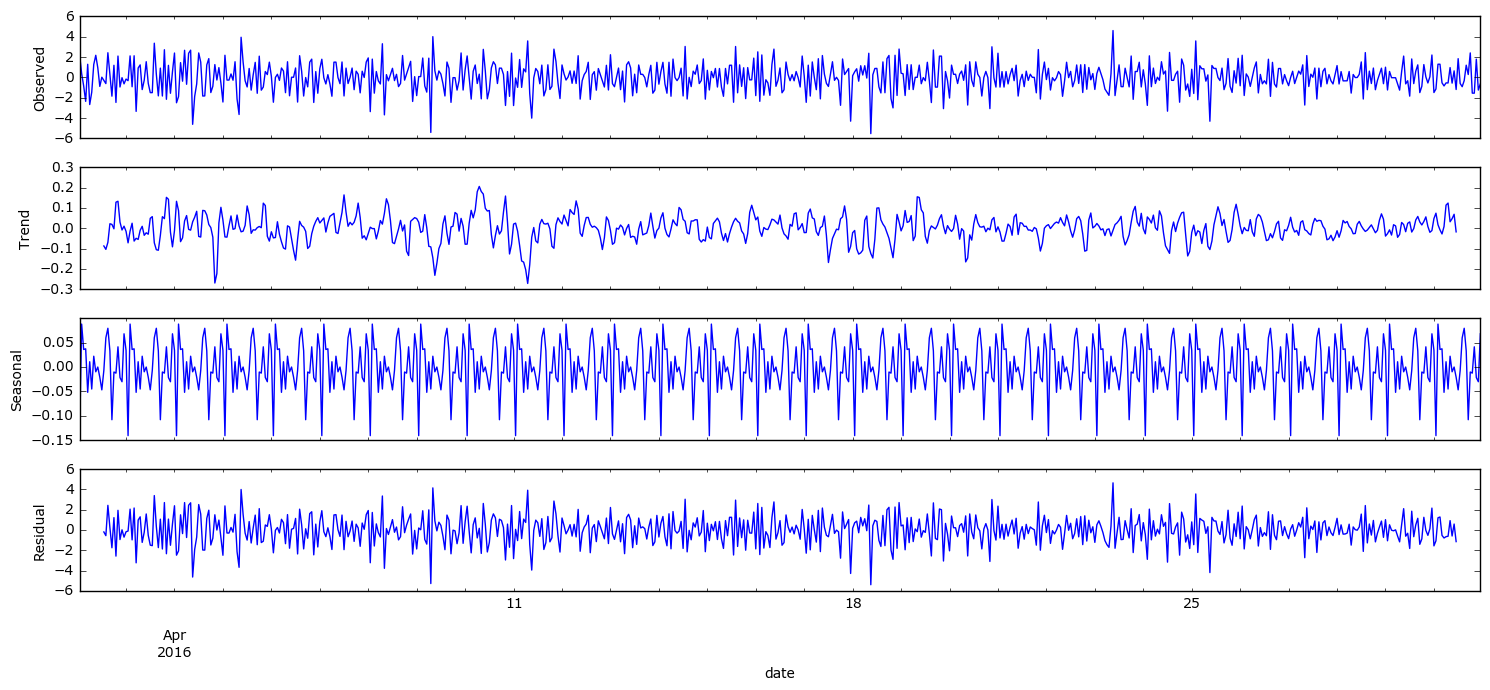

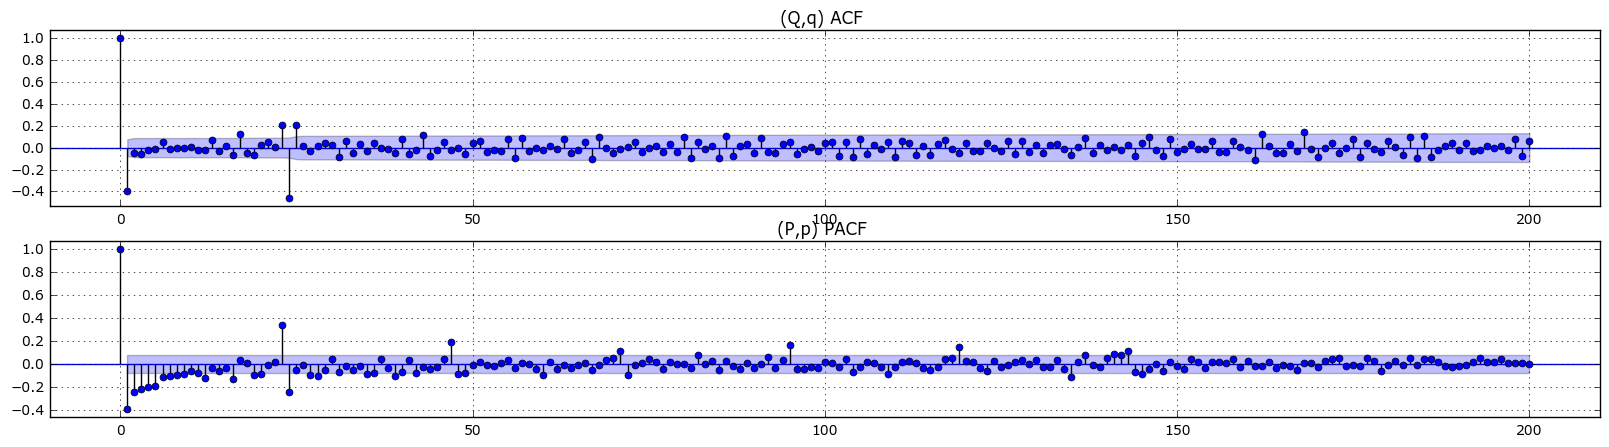

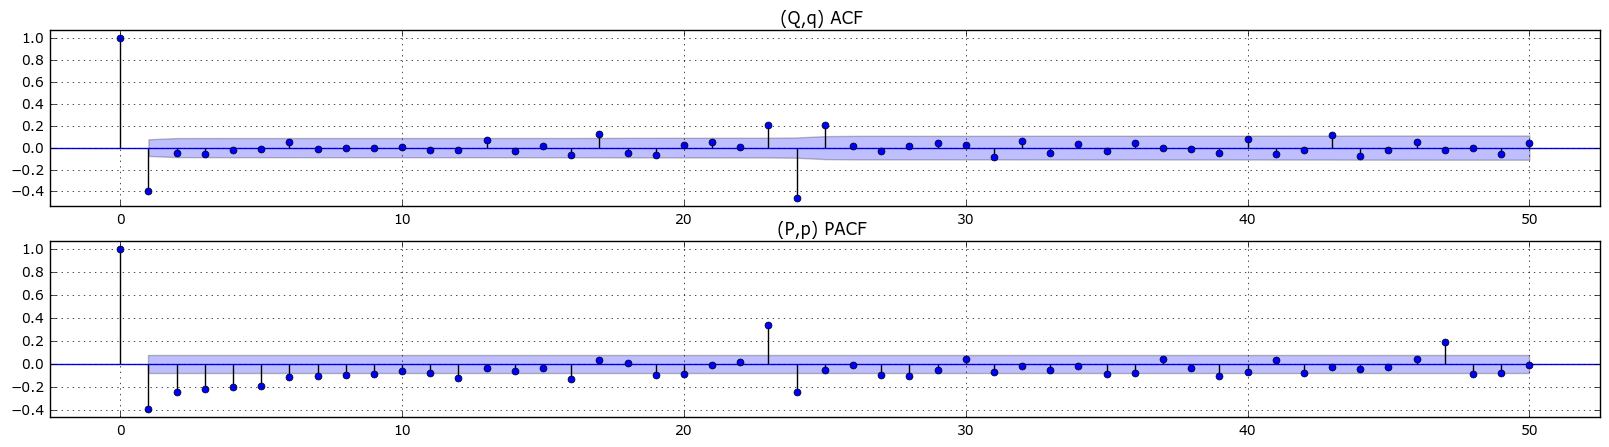

In [30]:
diff(centers_, 4, april, CALCULATE_PARAMETERS) 

In [31]:
# Подбор начальных параметров аримы для кластера 4

ps=[1,5,7]
ds=[1]
qs=[1]
Ps=[1,2]
Ds=[1]
Qs=[1]

list_of_parameters_list.append( list(product(ps, ds, qs, Ps, Ds, Qs)) )
print( len(list_of_parameters_list[-1]), 'наборов параметров') 


6 наборов параметров


In [32]:
print(  len( list_of_parameters_list) )

5


# Обучение

In [33]:
print('всего наборов параметров ', sum([len(param_list) for param_list in list_of_parameters_list]))


всего наборов параметров  174


### Обучение май

In [34]:
april_arimas = arimas_class(arima_train_period = jan.union(feb).union(mar), 
                            train_period_id = 'mar',
                            arima_test_period = april,
                            path='4week_models/may/')

In [35]:
%%time

april_arimas.get_best_params(CALCULATE_PARAMETERS&MAY)



 144 parameters for cluster 0


   cluster_id = 0 
best_params: 
AIC                           -2002.16
Q                             -2002.16
param              (1, 1, 11, 2, 1, 1)
train_period_id                    mar
Name: 0, dtype: object

 6 parameters for cluster 1


   cluster_id = 1 
best_params: 
AIC                            4201.58
Q                              4201.58
param              (10, 1, 1, 1, 1, 1)
train_period_id                    mar
Name: 1, dtype: object

 10 parameters for cluster 2


   cluster_id = 2 
best_params: 
AIC                           5856.89
Q                             5856.89
param              (6, 1, 1, 2, 1, 1)
train_period_id                   mar
Name: 2, dtype: object

 8 parameters for cluster 3


   cluster_id = 3 
best_params: 
AIC                           4673.59
Q                             4673.59
param              (7, 1, 1, 1, 1, 1)
train_period_id                   mar
Name: 3, dtype: object

 6 parameters for cluster 4


  

AIC            Q                param train_period_id
0 -2002.159357 -2002.159357  (1, 1, 11, 2, 1, 1)             mar
1  4201.580402  4201.580402  (10, 1, 1, 1, 1, 1)             mar
2  5856.894640  5856.894640   (6, 1, 1, 2, 1, 1)             mar
3  4673.590642  4673.590642   (7, 1, 1, 1, 1, 1)             mar
4  5724.979348  5724.979348   (7, 1, 1, 1, 1, 1)             mar

### Обучение июнь

In [36]:
may_arimas = arimas_class(arima_train_period = jan.union(feb).union(mar).union(april), 
                          train_period_id = 'april',
                          arima_test_period = may,
                          path='4week_models/june/')

In [38]:
%%time
may_arimas.get_best_params(calculate=CALCULATE_PARAMETERS&JUNE)


 144 parameters for cluster 0


   cluster_id = 0 
best_params: 
AIC                            -2908.1
Q                              -2908.1
param              (1, 1, 11, 2, 1, 1)
train_period_id                  april
Name: 0, dtype: object

 6 parameters for cluster 1


   cluster_id = 1 
best_params: 
AIC                            5671.65
Q                              5671.65
param              (10, 1, 1, 1, 1, 1)
train_period_id                  april
Name: 1, dtype: object

 10 parameters for cluster 2


   cluster_id = 2 
best_params: 
AIC                           7750.32
Q                             7750.32
param              (9, 1, 1, 2, 1, 1)
train_period_id                 april
Name: 2, dtype: object

 8 parameters for cluster 3


   cluster_id = 3 
best_params: 
AIC                           6677.34
Q                             6677.34
param              (7, 1, 1, 1, 1, 1)
train_period_id                 april
Name: 3, dtype: object

 6 parameters for cluster 4


  

AIC            Q                param train_period_id
0 -2908.102127 -2908.102127  (1, 1, 11, 2, 1, 1)           april
1  5671.649940  5671.649940  (10, 1, 1, 1, 1, 1)           april
2  7750.322975  7750.322975   (9, 1, 1, 2, 1, 1)           april
3  6677.343359  6677.343359   (7, 1, 1, 1, 1, 1)           april
4  7540.250273  7540.250273   (7, 1, 1, 2, 1, 1)           april

### Посмотрим на остатки АРИМЫ

In [39]:

def show_center_arima_residues(cluster_id, arima_obj, verbose=False):

    best_model = arima_obj.heavy_arima(cluster_id).model
    acf_shift = 25

    if verbose:
        plt.figure(figsize(15,8))
        plt.subplot(211)
        best_model.resid[acf_shift:].plot()
        plt.ylabel(u'Residuals')
        ax = plt.subplot(212)
        sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze()[acf_shift:], lags=48, ax=ax)

    print('best_model.resid.mean()', best_model.resid.mean())
    print("Критерий Стьюдента на равенство средней нулю: p=%f" % stats.ttest_1samp(best_model.resid[acf_shift:], 0)[1])
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[acf_shift:])[1])

best_model.resid.mean() 0.00801845637637354
Критерий Стьюдента на равенство средней нулю: p=0.007247
Критерий Дики-Фуллера: p=0.000000


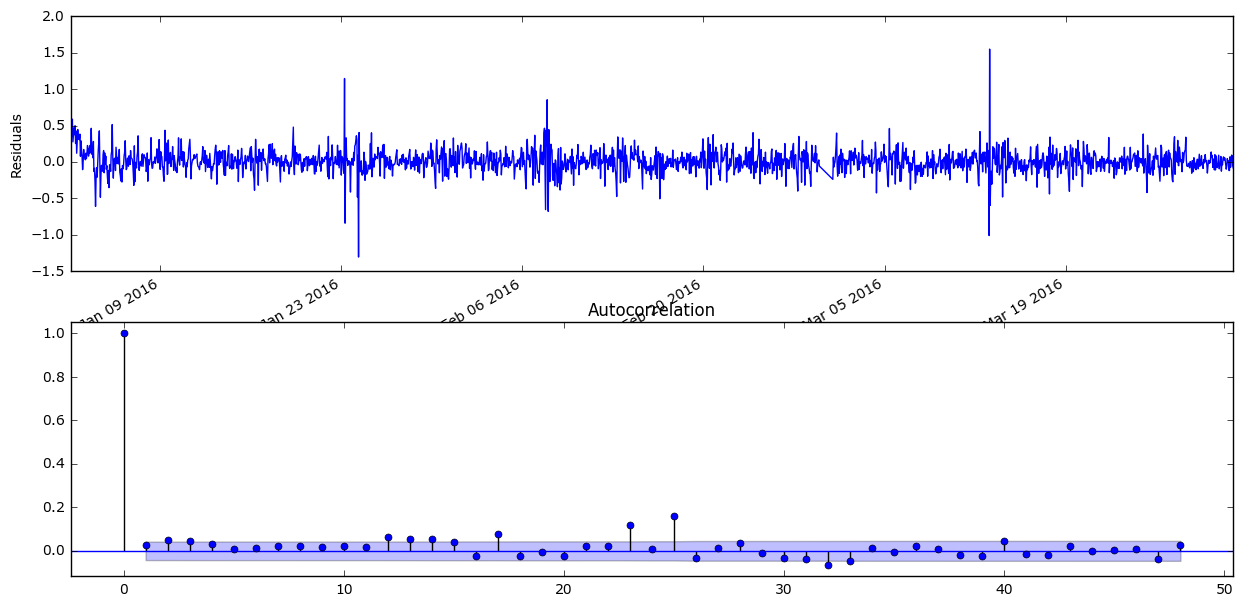

In [40]:
if MAY:
    show_center_arima_residues(cluster_id = 0, arima_obj=april_arimas, verbose=True)

best_model.resid.mean() 0.053446360662542505
Критерий Стьюдента на равенство средней нулю: p=0.000010
Критерий Дики-Фуллера: p=0.000000


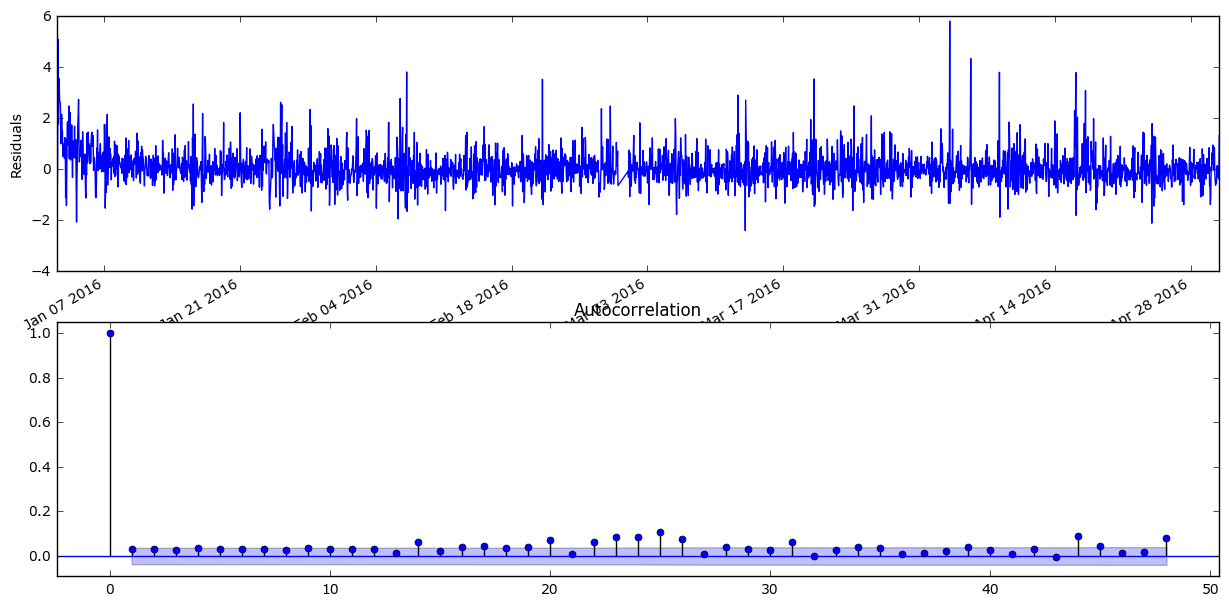

In [41]:
if JUNE:
    show_center_arima_residues(1, may_arimas, verbose=True)

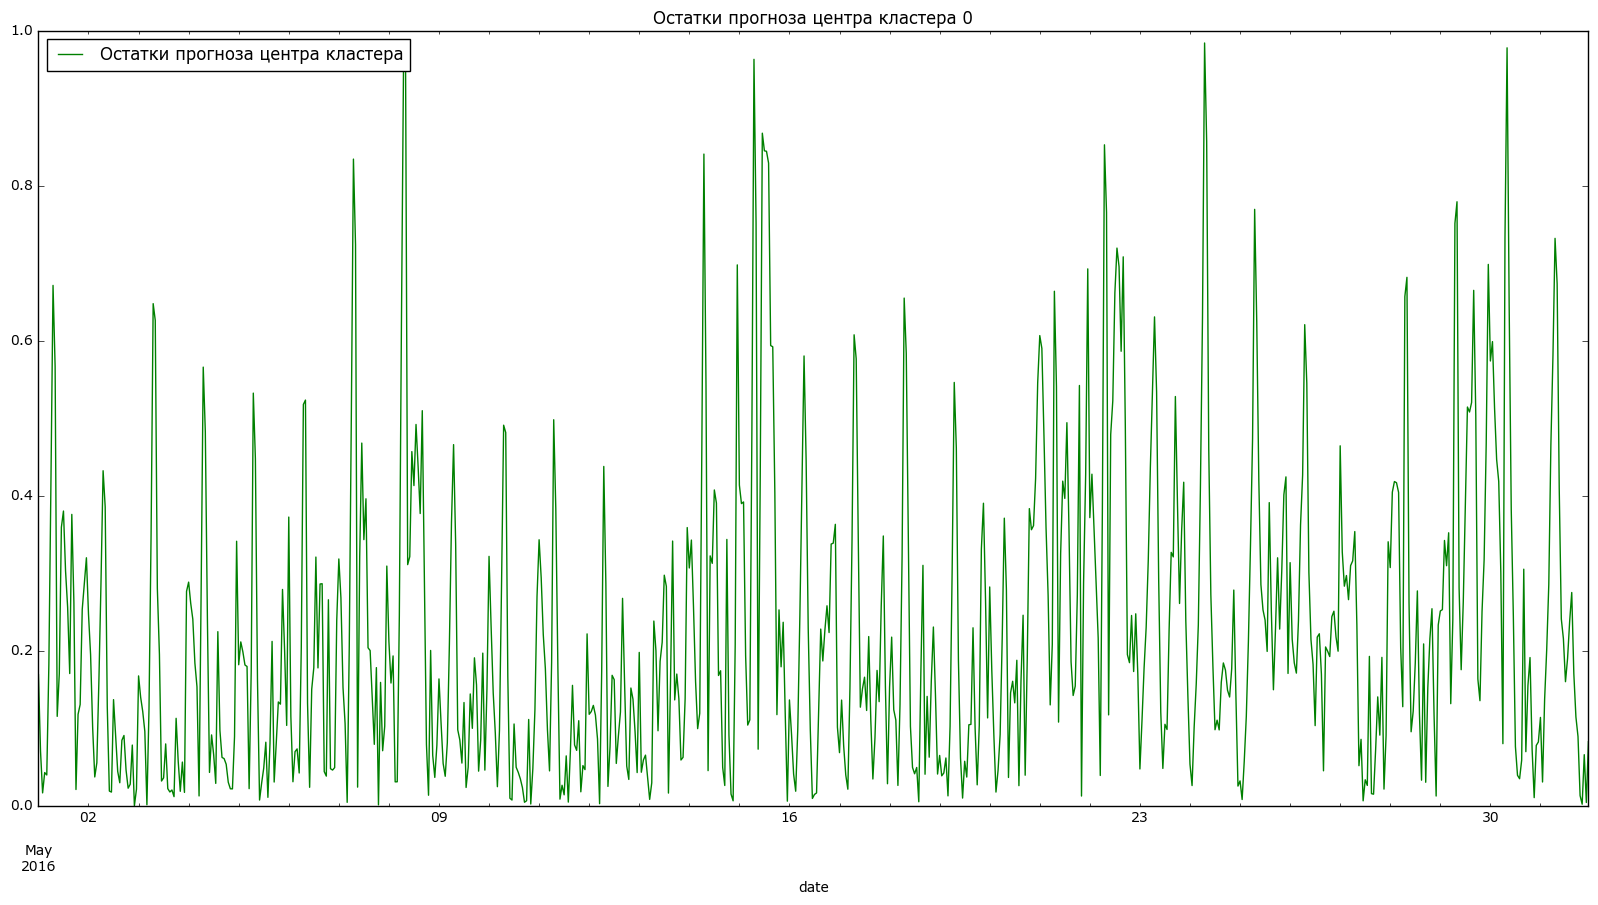

In [42]:
if JUNE:
    may_arimas.test_period_forecast_residues(0)

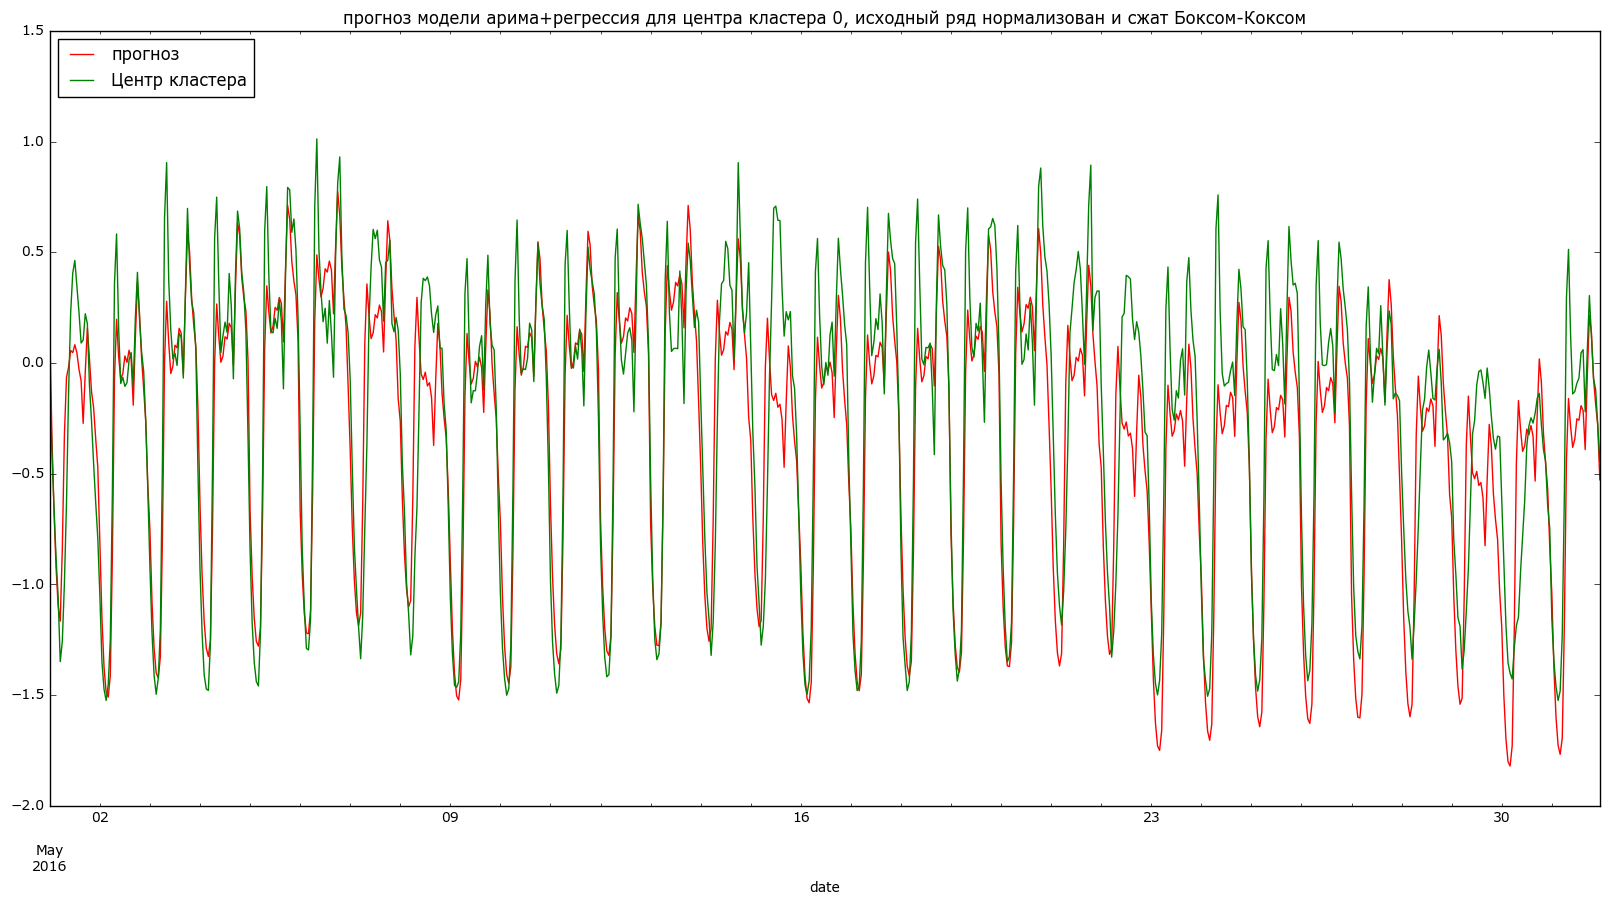

In [43]:
if JUNE:
    may_arimas.test_period_forecast(0)

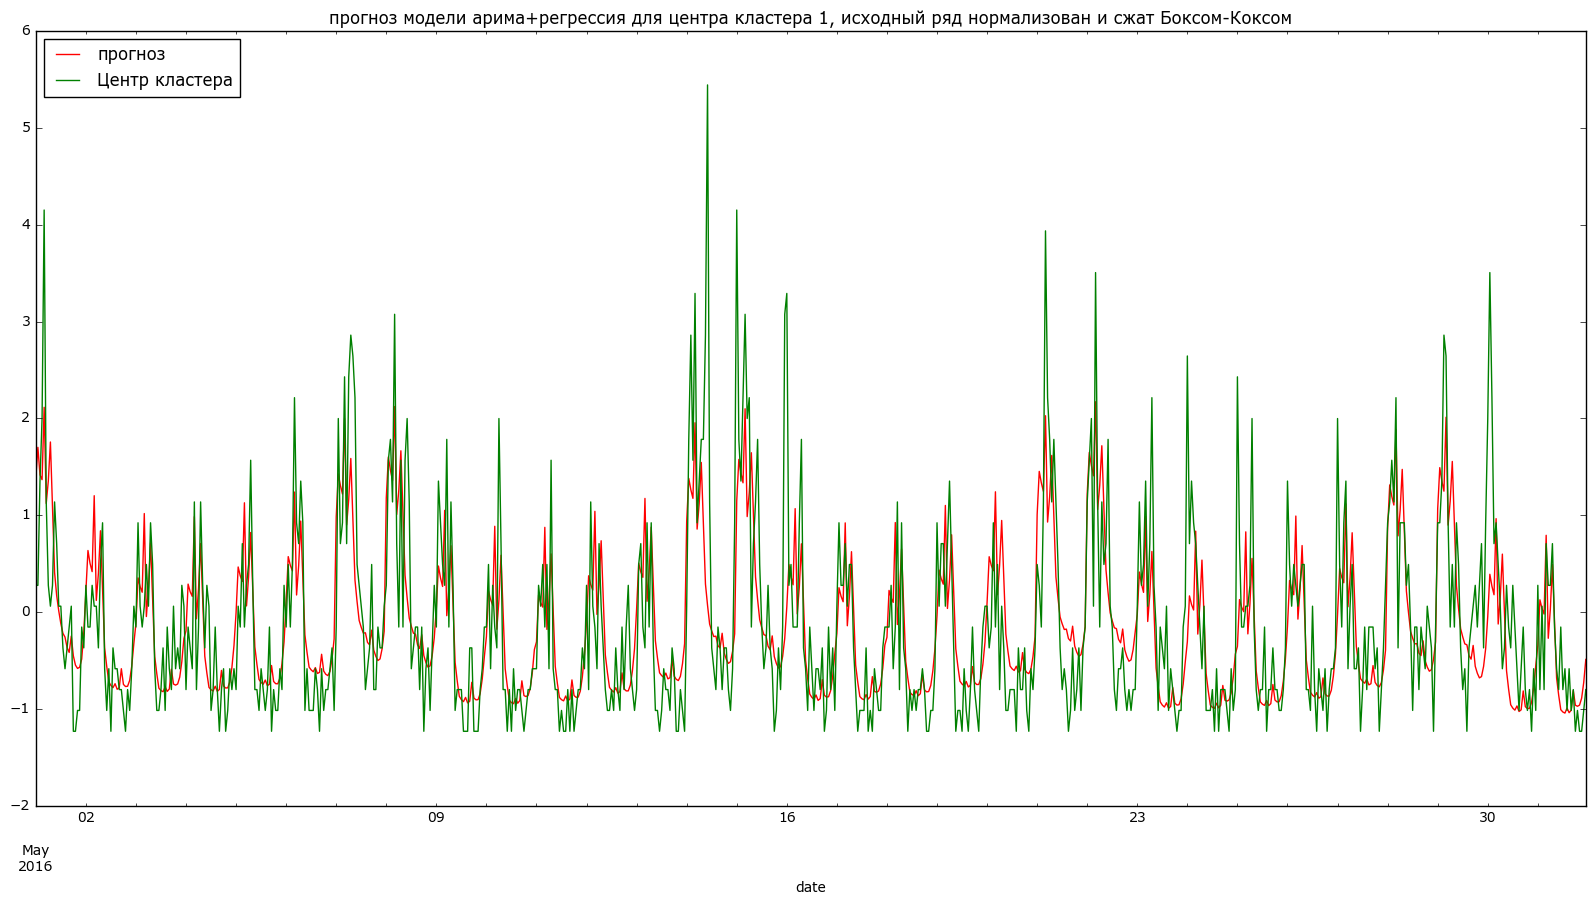

In [44]:
if JUNE:
    may_arimas.test_period_forecast(1)

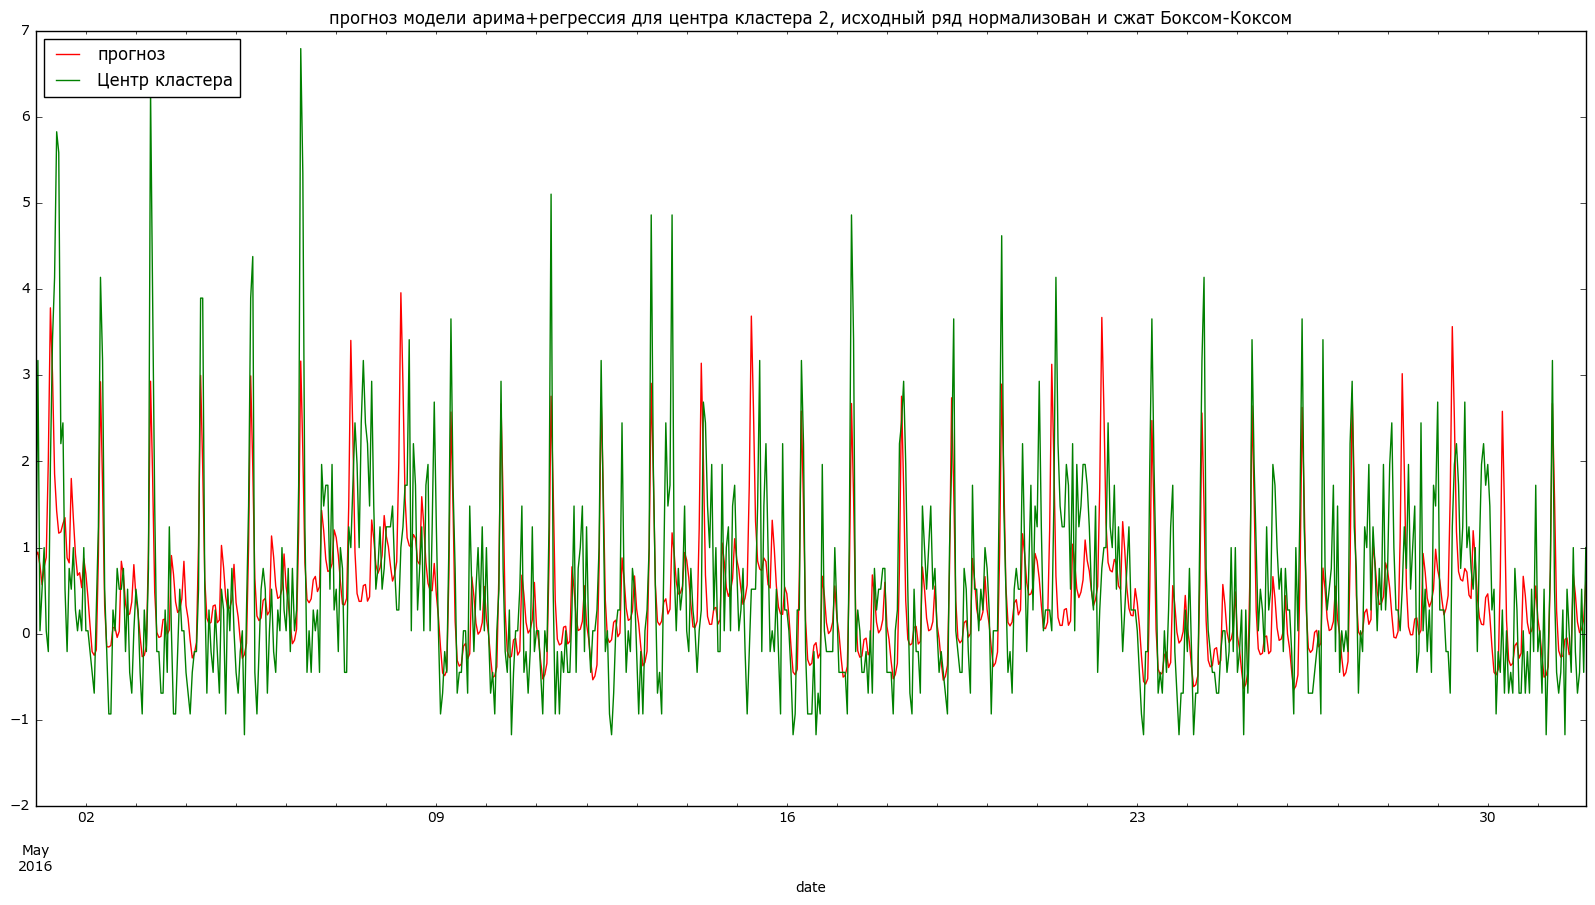

In [45]:
if JUNE:
    may_arimas.test_period_forecast(2)

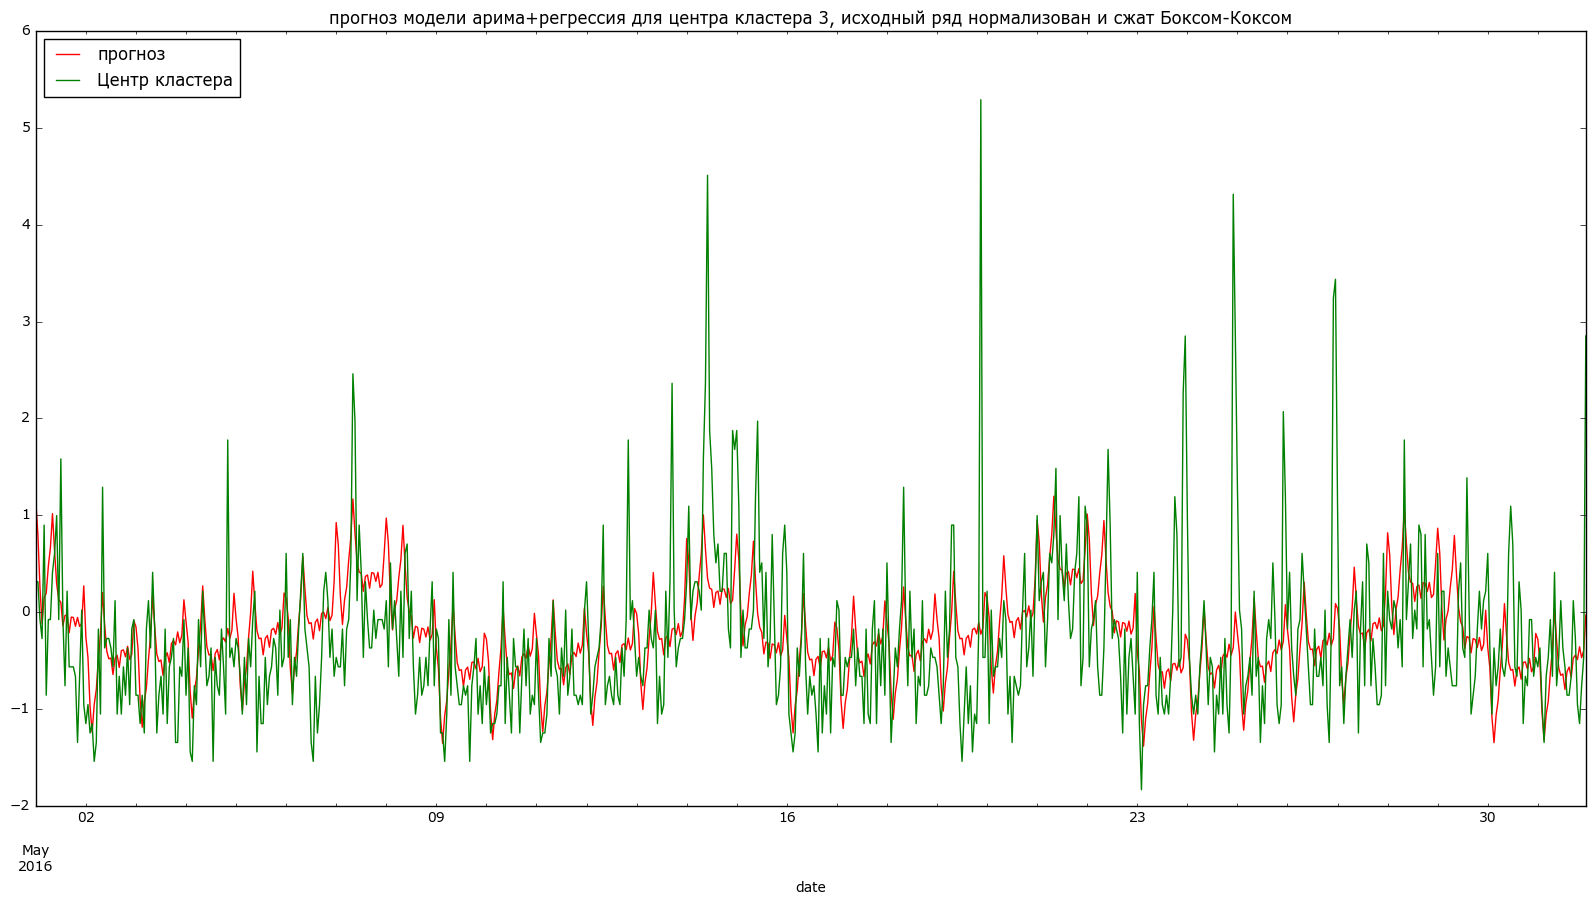

In [46]:
if JUNE:
    may_arimas.test_period_forecast(3)

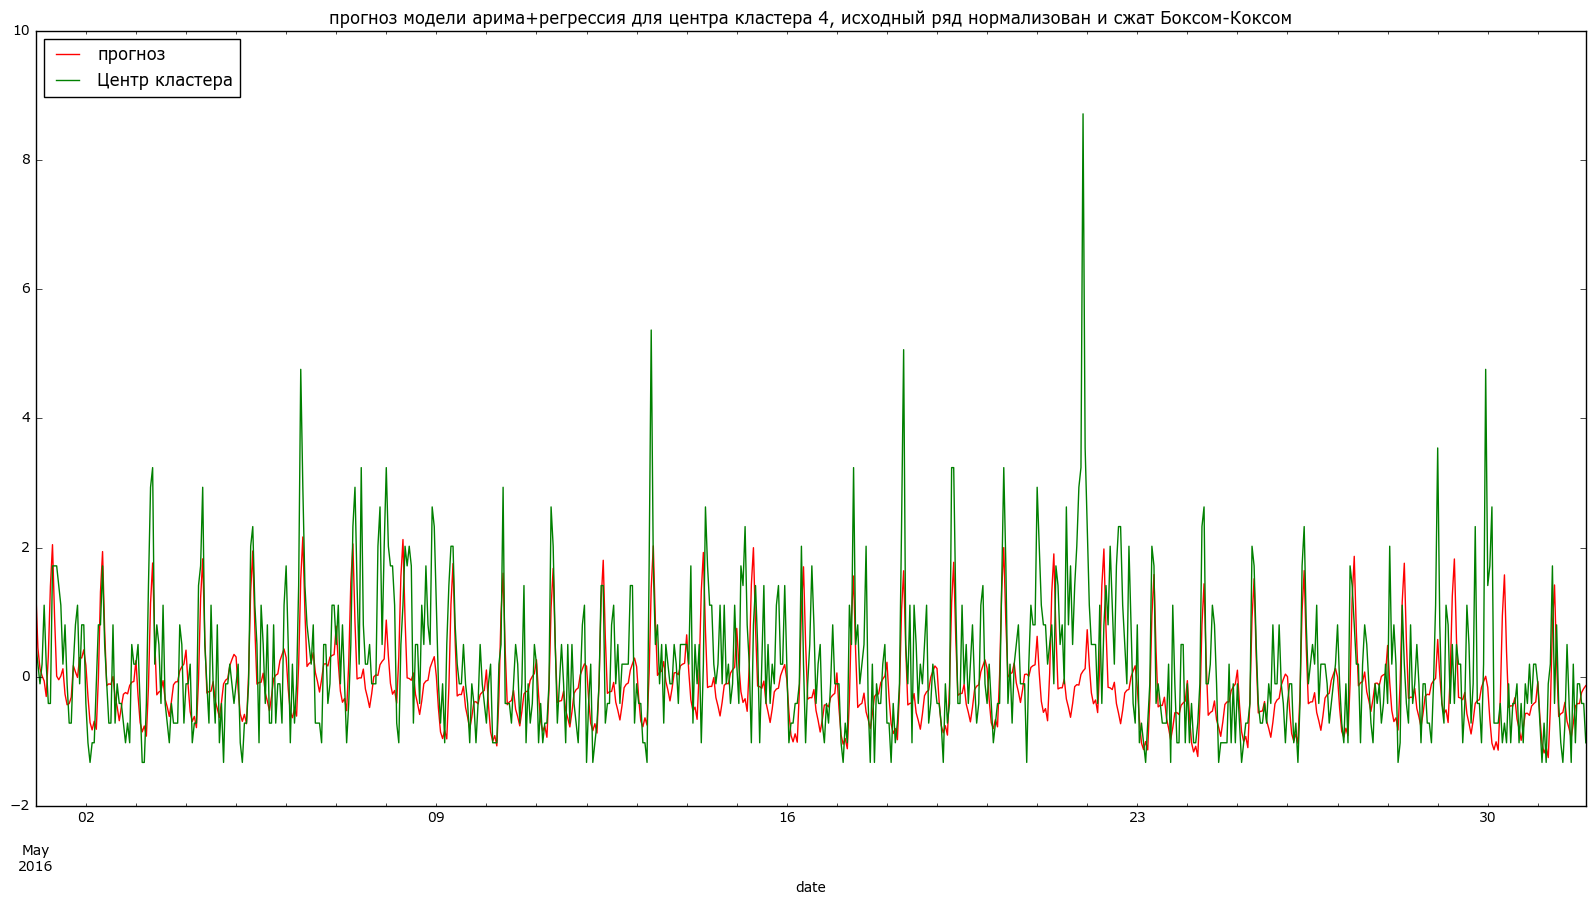

In [47]:
if JUNE:
    may_arimas.test_period_forecast(4)

## Построение прогноза

In [48]:
%%time
# ~5minutes
# Регрессия нормализованных рядов исходных данных каждого региона на сезонные признаки
# К прогнозу (внутрисуточному) аримы для каждого кластера потом будем прибавлять прогноз этой сезонной регрессии
# таким образом получим конечный прогноз

regions_ = get_regions(CALCULATE_REGIONS)
regions_forecast = pd.DataFrame(np.array([forecast.ols_forecast for forecast in regions_]).T, index = y.index, columns = y.columns )
regions_residues = pd.DataFrame(np.array([residues.ols_resid for residues in regions_]).T, index = y.index, columns = y.columns )


Wall time: 5min 9s


###  Прогноз на май

In [49]:
%%time
# ~7hours
may_predict_dynamic = april_arimas.predict_dynamic(data=regions_residues,
    test_period_id='may_', 
    dynamic_test_period=may_test_per, 
    calculate=CALCULATE_PREDICTION&MAY)

cluster 0


KeyboardInterrupt: 

In [ ]:
# Q вычисляет искомую метрику. У меня точно с лидербордом не сходится 
def Q(data_predict, test_per):

    forecast=pd.DataFrame()
    ydata_dynamic=pd.DataFrame()

    for i, ind in enumerate(test_per):
        time_horizon = pd.date_range(start=ind, periods=6, freq='h')

#        time_horizon_index = [ind.strftime('%Y-%m-%d_%H_')+str(i+1) for i in  np.arange(len(time_horizon))]
        time_horizon_index = ['{0}_{1}_{2}'.format(ind.strftime('%Y-%m-%d'), ind.hour, i+1) for i in  np.arange(len(time_horizon))]
        
        dynamic_predict = pd.DataFrame(data=may_predict_dynamic.loc[i*6:i*6+5].values + 
                         regions_forecast.loc[time_horizon].values, index=time_horizon_index, columns=y.columns)
        forecast = forecast.append(dynamic_predict)

        y_dynamic = pd.DataFrame(data=ydata.loc[time_horizon].values, index=time_horizon_index, columns=ydata.columns)
        ydata_dynamic = ydata_dynamic.append(y_dynamic)
    
    forecast_inversed = pd.DataFrame()

    for col, norm in zip(forecast, normalize_list):
        forecast_inversed[col] = np.round(( norm.inverse(forecast[col]).values), 0)
        forecast_inversed[col].loc[forecast_inversed[col] < 0] = 0

    forecast_inversed.index = forecast.index
    
    R = len(y.columns)
    N = len(test_per)
    
    Q = np.sum( abs( (ydata_dynamic-forecast_inversed).values) )/(N*6*R)
    print('Q=', Q)
    return Q, forecast_inversed
    
    

In [ ]:
if CALCULATE_PREDICTION&MAY:
    q, forecast_may = Q(may_predict_dynamic, may_test_per)
    
    answer_may = pd.Series()
    for col in forecast_may:
        index = col+'_'+forecast_may.index
        a = pd.Series(data=forecast_may[col].values, index = index)
        answer_may = answer_may.append(a)


    answer_may.head(10)


### Прогноз на июнь

In [ ]:
%%time
june_test_per_test = june_test_per
june_predict_dynamic = may_arimas.predict_dynamic(data=regions_residues,
    test_period_id='june_', 
    dynamic_test_period=june_test_per_test, 
    calculate=CALCULATE_PREDICTION&JUNE)

In [ ]:
q, forecast_june = Q(june_predict_dynamic, june_test_per_test)

answer_june = pd.DataFrame()
for col in forecast_june:
    index = col+'_'+forecast_june.index
    a = pd.DataFrame(data=forecast_june[col].values, index = index)
    answer_june = answer_june.append(a)



In [ ]:
%%time


answer_j = answer_june.apply(lambda x: str(x.name)+','+str(int(x[0])), axis=1).values

print(answer_j.shape)

In [ ]:
# Функция сохранения в файл конечного прогноза
def save_answer_week4(fname, answer ):
    with open(fname,"w") as fout:
        fout.write('id,y\n')
        fout.write("\n".join([el for el in answer]))


In [ ]:
save_answer_week4('week4_answer.csv', answer_j)